# Download and process sentinel 2 data

## John Brandt
## April 1, 2020

## Package imports, API import, source scripts

In [9]:
import pandas as pd
import numpy as np
from random import shuffle
from osgeo import ogr, osr
from sentinelhub import WmsRequest, WcsRequest, MimeType, CRS, BBox, constants, DataSource, CustomUrlParam
from s2cloudless import S2PixelCloudDetector, CloudMaskRequest
import logging
from collections import Counter
import datetime
import os
import yaml

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from skimage.transform import resize

import scipy.sparse as sparse
from scipy.sparse.linalg import splu


with open("../config.yaml", 'r') as stream:
        key = (yaml.safe_load(stream))
        API_KEY = key['key'] 
        
%run ../src/slope.py
%run ../src/utils-bilinear.py
%run ../src/dsen2/utils/DSen2Net.py

## Parameters

In [11]:
time = ('2018-12-15', '2020-01-15')
EPSG = CRS.WGS84
IMSIZE = 48
cloud_detector = S2PixelCloudDetector(threshold=0.4, average_over=4, dilation_size=2)
MDL_PATH = "../src/dsen2/models/"

input_shape = ((4, None, None), (6, None, None))
model = s2model(input_shape, num_layers=6, feature_size=128)
predict_file = MDL_PATH+'s2_032_lr_1e-04.hdf5'

model.load_weights(predict_file)


c_arr = np.array([[1, 1, 1, 1, 1,],
                  [1, 2, 2, 2, 1,],
                  [1, 2, 3, 2, 1,],
                  [1, 2, 2, 2, 1,],
                  [1, 1, 1, 1, 1,],])
                  
c_arr = c_arr / 3
o_arr = 1 - c_arr
c_arr = np.tile(c_arr[:, :, np.newaxis], (1, 1, 11))
o_arr = np.tile(o_arr[:, :, np.newaxis], (1, 1, 11))

# Helper functions

In [12]:
def calculate_proximal_steps_index(date, satisfactory):
    """Returns proximal steps that are cloud and shadow free

         Parameters:
         date (int): current time step
         satisfactory (list): time steps with no clouds or shadows

         Returns:
         arg_before (str): index of the prior clean image
         arg_after (int): index of the next clean image

    """
    arg_before, arg_after = None, None
    if date > 0:
        idx_before = satisfactory - date
        arg_before = idx_before[np.where(idx_before < 0, idx_before, -np.inf).argmax()]
    if date < np.max(satisfactory):
        idx_after = satisfactory - date
        arg_after = idx_after[np.where(idx_after > 0, idx_after, np.inf).argmin()]
    if not arg_after and not arg_before:
        arg_after = date
        arg_before = date
    if not arg_after:
        arg_after = arg_before
    if not arg_before:
        arg_before = arg_after
    return arg_before, arg_after

def speyediff(N, d, format = 'csc'):
    """Calculates the d-th order sparse difference matrix based on 
        an initial N x N identity matrix

         Parameters:
         N (int): input length
         d (int): smoothing order

         Returns:
         spmat (arr): sparse difference matrix
    """
    shape = (N-d, N)
    diagonals = np.zeros(2*d + 1)
    diagonals[d] = 1.
    for i in range(d):
        diff = diagonals[:-1] - diagonals[1:]
        diagonals = diff
    offsets = np.arange(d+1)
    spmat = sparse.diags(diagonals, offsets, shape, format = format)
    return spmat

def smooth(y, lmbd, d = 2):
    """Calculates the whittaker smoother on input array

         Parameters:
         y (arr): 1-dimensional input array
         lmbd (int): degree of smoothing, higher is more

         Returns:
         z (arr): smoothed version of y
    """
    m = len(y)
    E = sparse.eye(m, format = 'csc')
    D = speyediff(m, d, format = 'csc')
    coefmat = E + lmbd * D.conj().T.dot(D)
    z = splu(coefmat).solve(y)
    return z

def DSen2(d10, d20):
    """Super resolves 20 meter bans using the DSen2 convolutional
       neural network, as specified in Lanaras et al. 2018
       https://github.com/lanha/DSen2

        Parameters:
        d10 (arr): (4, X, Y) shape array with 10 meter resolution
        d20 (arr): (6, X, Y) shape array with 20 meter resolution

        Returns:
        prediction (arr): (6, X, Y) shape array with 10 meter superresolved
                          output of DSen2 on d20 array
    """
    test = [d10, d20]
    input_shape = ((4, None, None), (6, None, None))
    prediction = _predict(test, input_shape, deep=False)
    #prediction *= 5
    return prediction

def _predict(test, input_shape, model = model, deep=False, run_60=False):
    
    print("Predicting using file: {}".format(predict_file))
    prediction = model.predict(test, verbose=1)
    return prediction

Symbolic Model Created.


# Bounding boxes

In [13]:
def convertCoords(xy, src='', targ=''):
    """ Converts coords from one EPSG to another

        Parameters:
        xy (tuple): input longitiude, latitude tuple
        src (str): EPSG code associated with xy
        targ (str): EPSG code of target output
    
        Returns:
        pt (tuple): (x, y) tuple of xy in targ EPSG
    """

    srcproj = osr.SpatialReference()
    srcproj.ImportFromEPSG(src)
    targproj = osr.SpatialReference()
    if isinstance(targ, str):
        targproj.ImportFromProj4(targ)
    else:
        targproj.ImportFromEPSG(targ)
    transform = osr.CoordinateTransformation(srcproj, targproj)

    pt = ogr.Geometry(ogr.wkbPoint)
    pt.AddPoint(xy[0], xy[1])
    pt.Transform(transform)
    return([pt.GetX(), pt.GetY()])

def calculate_epsg(points):
    """ Calculates the UTM EPSG of an input WGS 84 lon, lat

        Parameters:
        points (tuple): input longitiude, latitude tuple
    
        Returns:
        epsg_code (int): integer form of associated UTM EPSG
    """
    lon, lat = points[0], points[1]
    print(lon, lat)
    utm_band = str((math.floor((lon + 180) / 6 ) % 60) + 1)
    if len(utm_band) == 1:
        utm_band = '0'+utm_band
    if lat >= 0:
        epsg_code = '326' + utm_band
    else:
        epsg_code = '327' + utm_band
    return int(epsg_code)
    

def calc_bbox(plot_id, df):
    """ Calculates the corners of a bounding box from an input
        pandas dataframe as output by Collect Earth Online

        Parameters:
        plot_id (int): plot_id of associated plot
        df (pandas.DataFrame): dataframe of associated CEO survey
    
        Returns:
        bounding_box (list): [(min(x), min(y)),
                              (max(x), max_y))]
    """
    subs = df[df['PLOT_ID'] == plot_id]
    # TOP, LEFT, BOTTOM, RIGHT
    # (min x, min y), (max x, max y)
    return [(min(subs['LON']), min(subs['LAT'])),
            (max(subs['LON']), max(subs['LAT']))]

def bounding_box(points, expansion = 160):
    """ Calculates the corners of a bounding box with an
        input expansion in meters from a given bounding_box
        
         Subcalls:
         calculate_epsg, convertCoords

         Parameters:
         points (list): output of calc_bbox
         expansion (float): number of meters to expand or shrink the
                            points edges to be
    
         Returns:
         bl (tuple): x, y of bottom left corner with edges of expansion meters
         tr (tuple): x, y of top right corner with edges of expansion meters
    """
    # LONG, LAT FOR SOME REASON
    bl = list(points[0])
    tr = list(points[1])
    
    epsg = calculate_epsg(bl)
    bl = convertCoords(bl, 4326, epsg)
    tr = convertCoords(tr, 4326, epsg)
    init = [b - a for a,b in zip(bl, tr)]
    distance1 = tr[0] - bl[0]
    distance2 = tr[1] - bl[1]
    expansion1 = (expansion - distance1)/2
    expansion2 = (expansion - distance2)/2
    bl = [bl[0] - expansion1, bl[1] - expansion2]
    tr = [tr[0] + expansion1, tr[1] + expansion2]

    after = [b - a for a,b in zip(bl, tr)]   
    diffs = [b - a for b, a in zip(after, init)]

    bl = convertCoords(bl, epsg, 4326)
    tr = convertCoords(tr, epsg, 4326)
    return bl, tr

# Data download

In [14]:
def rank_array(arr):
    order = arr.argsort()
    ranks = order.argsort()
    return ranks

def mcm_shadow_mask(arr, c_probs):
    #' From "Cloud and cloud shadow masking for Sentinel-2 using multi-
    #         temporal images in global area. Candra et al. 2020."
    #'[B02,B03,B04, B08, B05,B06,B07, B8A,B11,B12]
    #'[B01,B02,B04,B05,B08,B8A,B09,B10,B11,B12]
    #'[ 0 , 1 , 2 , 3  , 4  , 5,  6   7  , 8  , 9]'
    mean_c_probs = np.mean(c_probs, axis = (1, 2))
    cloudy_steps = np.argwhere(mean_c_probs > 0.25)
    images_clean = np.delete(arr, cloudy_steps, 0)
    cloud_ranks = rank_array(mean_c_probs)
    diffs = abs(np.sum(arr - np.mean(images_clean, axis = 0), axis = (1, 2, 3)))
    diff_ranks = rank_array(diffs)
    overall_rank = diff_ranks + cloud_ranks
    reference_idx = np.argmin(overall_rank)
    ri = arr[reference_idx]
    print(reference_idx)
    
    nir_means = np.mean(arr[:, :, :, 4], axis = (0))
    
    shadows = np.zeros((arr.shape[0], 96, 96))    
    # Candra et al. 2020
    
    for time in range(arr.shape[0]):
        for x in range(arr.shape[1]):
            for y in range(arr.shape[2]):
                ti_slice = arr[time, x, y]
                ri_slice = ri[x, y]
                deltab2 = ti_slice[1] - ri_slice[1]
                deltab3 = ti_slice[2] - ri_slice[2]
                deltab4 = ti_slice[3] - ri_slice[3]
                deltab8a = ti_slice[6] - ri_slice[6]
                deltab11 = ti_slice[8] - ri_slice[8]

                if deltab2 < 0.1:
                    if deltab3 < 0.08:
                        if deltab4 < 0.08:
                            if deltab8a < -0.04:
                                if deltab11 < -0.04:
                                    if ti_slice[1] < 0.0950:
                                        shadows[time, x, y] = 1.
    print(np.sum(shadows, axis = (1, 2)))
                                        
    # Additional 3 time-window NIR thresholding
    '''
    for time in range(shadows.shape[0]):
        for x in range(shadows.shape[1]):
            for y in range(shadows.shape[2]):
                if shadows[time, x, y] == 1:
                    time_adjusted = np.max([time, 1])
                    time_adjusted = np.min([time_adjusted, shadows.shape[0] - 2])
                    # check before and after
                    if shadows[time_adjusted + 1, x, y] == 1 or shadows[time_adjusted-1, x, y] == 1:
                        nir_mean = nir_means[x, y]
                        nir_before = arr[time_adjusted - 1, x, y, 4] - nir_mean
                        nir_now = arr[time, x, y, 4] - nir_mean
                        nir_next = arr[time_adjusted + 1, x, y, 4] - nir_mean
                        if nir_now > nir_mean * 0.75:
                            shadows[time, x, y] = 0
                        if nir_next or nir_before <= nir_now:
                            shadows[time, x, y] = 0
                         
    print(np.sum(shadows, axis = (1, 2)))
    '''
    # Remove shadows if cannot coreference a cloud
    shadow_large = np.reshape(shadows, (shadows.shape[0], 96//8, 8, 96//8, 8))
    shadow_large = np.sum(shadow_large, axis = (2, 4))
    
    cloud_large = np.copy(c_probs)
    cloud_large[np.where(c_probs > 0.33)] = 1.
    cloud_large[np.where(c_probs < 0.33)] = 0.
    cloud_large = np.reshape(cloud_large, (shadows.shape[0], 96//8, 8, 96//8, 8))
    cloud_large = np.sum(cloud_large, axis = (2, 4))
    for time in range(shadow_large.shape[0]):
        for x in range(shadow_large.shape[1]):
            x_low = np.max([x - 8, 0])
            x_high = np.min([x + 8, shadow_large.shape[1] - 1])
            for y in range(shadow_large.shape[2]):
                y_low = np.max([y - 8, 0])
                y_high = np.min([y + 8, shadow_large.shape[1] - 1])
                if shadow_large[time, x, y] < 8:
                    shadow_large[time, x, y] = 0.
                if shadow_large[time, x, y] >= 8:
                    shadow_large[time, x, y] = 1.
                c_prob_window = cloud_large[time, x_low:x_high, y_low:y_high]
                if np.max(c_prob_window) < 24:
                    shadow_large[time, x, y] = 0.
                    
    
    shadow_large = resize(shadow_large, (shadow_large.shape[0], 96, 96), order = 0)
    shadows *= shadow_large
    print(np.sum(shadows, axis = (1, 2)))
    
    # Go through and aggregate the shadow map to an 80m grid, and extend it one grid size around
    # any positive ID
    
    shadows_original = np.copy(shadows)
    shadows = np.reshape(shadows, (shadows.shape[0], 96//8, 8, 96//8, 8))
    shadows = np.sum(shadows, axis = (2, 4))
    shadows[np.where(shadows < 16)] = 0.
    shadows[np.where(shadows >= 16)] = 1.
    shadows = resize(shadows, (shadows.shape[0], 96, 96), order = 0)
    shadows = np.reshape(shadows, (shadows.shape[0], 96//4, 4, 96//4, 4))
    shadows = np.max(shadows, (2, 4))
    
    shadows_new = np.zeros_like(shadows)
    for time in range(shadows.shape[0]):
        for x in range(shadows.shape[1]):
            for y in range(shadows.shape[2]):
                if shadows[time, x, y] == 1:
                    min_x = np.max([x - 1, 0])
                    max_x = np.min([x + 2, shadows.shape[1] - 1])
                    min_y = np.max([y - 1, 0])
                    max_y = np.min([y + 2, shadows.shape[1] - 1])
                    for x_idx in range(min_x, max_x):
                        for y_idx in range(min_y, max_y):
                            shadows_new[time, x_idx, y_idx] = 1.
    shadows_new = resize(shadows_new, (shadows.shape[0], 96, 96), order = 0)
    print("The shadow probability is: {}".format(100*np.sum(shadows_new)/(96*96*shadows_new.shape[0])))
    print(np.sum(shadows_new, axis = (1, 2)))
    return shadows_new, shadows_original

def identify_clouds(bbox, epsg = EPSG, time = time):
    #try:
    box = BBox(bbox, crs = epsg)
    cloud_request = WmsRequest(
        layer='CLOUD_DETECTION',
        bbox=box,
        time=time,
        width=96,
        height=96,
        image_format = MimeType.TIFF_d32f,
        maxcc=0.75,
        instance_id=API_KEY,
        custom_url_params = {constants.CustomUrlParam.UPSAMPLING: 'NEAREST'},
        time_difference=datetime.timedelta(hours=48),
    )

    cloud_img = cloud_request.get_data()
    print(np.array(cloud_img).shape)
    cloud_probs = cloud_detector.get_cloud_probability_maps(np.array(cloud_img))
    shadows, shadow_original = mcm_shadow_mask(np.array(cloud_img), cloud_probs)
    shadows = shadows[:, 24:-24, 24:-24]
    return cloud_probs[:, 24:-24, 24:-24], shadows, shadow_original, cloud_probs
    #except Exception as e:
    #    logging.fatal(e, exc_info=True)
    
    
## ????
def download_dem(val, df, epsg = EPSG, ):
    location = calc_bbox(val, df = df)
    bbox = bounding_box(location, expansion = (IMSIZE+2)*10)
    box = BBox(bbox, crs = epsg)
    dem_request = WmsRequest(data_source=DataSource.DEM,
                         layer='DEM',
                         bbox=box,
                         width=IMSIZE+2,
                         height=IMSIZE+2,
                         instance_id=API_KEY,
                         image_format=MimeType.TIFF_d32f,
                         custom_url_params={CustomUrlParam.SHOWLOGO: False})
    dem_image = dem_request.get_data()[0]
    dem_image = calcSlope(dem_image.reshape((1, IMSIZE+2, IMSIZE+2)),
                  np.full((IMSIZE+2, IMSIZE+2), 10), np.full((IMSIZE+2, IMSIZE+2), 10), zScale = 1, minSlope = 0.02)
    dem_image = dem_image.reshape((IMSIZE+2, IMSIZE+2, 1))
    dem_image = dem_image[1:IMSIZE+1, 1:IMSIZE+1, :]
    print(dem_image.shape)
    return dem_image

def check_zenith(bbox, epsg = EPSG, time = time):
    try:
        box = BBox(bbox, crs = epsg)
        zenith = WmsRequest(
            layer='ZENITH',
            bbox=box,
            time=time,
            width=IMSIZE,
            height=IMSIZE,
            image_format = MimeType.TIFF_d32f,
            maxcc=0.75,
            instance_id=API_KEY,
            custom_url_params = {constants.CustomUrlParam.UPSAMPLING: 'NEAREST'},
            time_difference=datetime.timedelta(hours=48),
        )
        
        zenith = zenith.get_data()
        return zenith
    except Exception as e:
        logging.fatal(e, exc_info=True)
        
def download_layer(bbox, epsg = EPSG, time = time):
    try:
        box = BBox(bbox, crs = epsg)
        image_request = WcsRequest(
                layer='L2A20',
                bbox=box,
                time=time,
                image_format = MimeType.TIFF_d32f,
                maxcc=0.75,
                resx='10m', resy='10m',
                instance_id=API_KEY,
                custom_url_params = {constants.CustomUrlParam.DOWNSAMPLING: 'NEAREST',
                                    constants.CustomUrlParam.UPSAMPLING: 'NEAREST'},
                time_difference=datetime.timedelta(hours=48),
            )
        img_bands = image_request.get_data()
        img_20 = np.stack(img_bands)
        img_20 = resize(img_20, (img_20.shape[0], IMSIZE, IMSIZE, img_20.shape[-1]), order = 0)
        
        image_request = WcsRequest(
                layer='L2A10',
                bbox=box,
                time=time,
                image_format = MimeType.TIFF_d32f,
                maxcc=0.75,
                resx='10m', resy='10m',
                instance_id=API_KEY,
                custom_url_params = {constants.CustomUrlParam.DOWNSAMPLING: 'BICUBIC',
                                    constants.CustomUrlParam.UPSAMPLING: 'BICUBIC'},
                time_difference=datetime.timedelta(hours=48),
        )
        
        img_bands = image_request.get_data()
        img_10 = np.stack(img_bands)
        print("Original size: {}".format(img_10.shape))
        img_10 = resize(img_10, (img_10.shape[0], IMSIZE, IMSIZE, img_10.shape[-1]), order = 0)
        img = np.concatenate([img_10, img_20], axis = -1)
        return img, image_request

    except Exception as e:
        logging.fatal(e, exc_info=True)

# Cloud and shadow removal

In [16]:
def remove_cloud_and_shadows(tiles, probs, shadows, image_dates, wsize = 5):
    c_probs = np.copy(probs)
    c_probs = c_probs - np.min(c_probs, axis = 0)
    c_probs[np.where(c_probs > 0.33)] = 1.
    c_probs[np.where(c_probs < 0.33)] = 0.
    c_probs = np.reshape(c_probs, [c_probs.shape[0], int(IMSIZE/8), 8, int(IMSIZE/8), 8])
    c_probs = np.sum(c_probs, (2, 4))
    c_probs = resize(c_probs, (c_probs.shape[0], IMSIZE, IMSIZE), 0)
    c_probs[np.where(c_probs < 12)] = 0.
    c_probs[np.where(c_probs >= 12)] = 1.
    c_probs += shadows
    c_probs[np.where(c_probs >= 1.)] = 1.
    n_interp = 0
    for cval in range(0, IMSIZE - 5, 1):
        for rval in range(0, IMSIZE - 5, 1):
            subs = c_probs[:, cval:cval + wsize, rval:rval+wsize]
            satisfactory = [x for x in range(c_probs.shape[0]) if np.sum(subs[x, :, :]) < 10]
            satisfactory = np.array(satisfactory)
            for date in range(0, tiles.shape[0]):
                if np.sum(subs[date, :, :]) > 10:
                    n_interp += 1
                    before, after = calculate_proximal_steps_index(date, satisfactory)
                    before = date + before
                    after = date + after
                    bef = tiles[before, cval:cval+wsize, rval:rval+wsize, : ]
                    aft = tiles[after, cval:cval+wsize, rval:rval+wsize, : ]
                    before = image_dates[before]
                    after = image_dates[after]
                    before_diff = abs(image_dates[date] - before)
                    after_diff = abs(image_dates[date] - after)
                    bef_wt = 1 - before_diff / (before_diff + after_diff)
                    aft_wt = 1 - bef_wt
                    candidate = bef_wt*bef + aft_wt*aft
                    candidate = candidate*c_arr + tiles[date, cval:cval+wsize, rval:rval+wsize, : ]*o_arr
                    tiles[date, cval:cval+wsize, rval:rval+wsize, : ] = candidate  
    print("Interpolated {} px".format(n_interp))
    return tiles

def remove_missed_clouds(img):
    iqr = np.percentile(img[:, :, :, 3].flatten(), 75) - np.percentile(img[:, :, :, 3].flatten(), 25)
    thresh_t = np.percentile(img[:, :, :, 3].flatten(), 75) + iqr*2
    thresh_b = np.percentile(img[:, :, :, 3].flatten(), 25) - iqr*2
    diffs_fw = np.diff(img, 1, axis = 0)
    diffs_fw = np.mean(diffs_fw, axis = (1, 2, 3))
    diffs_fw = np.array([0] + list(diffs_fw))
    diffs_bw = np.diff(np.flip(img, 0), 1, axis = 0)
    diffs_bw = np.flip(np.mean(diffs_bw, axis = (1, 2, 3)))
    diffs_bw = np.array(list(diffs_bw) + [0])
    diffs = abs(diffs_fw - diffs_bw) * 100 # 3, -3 -> 6, -3, 3 -> 6, -3, -3
    #diffs = [int(x) for x in diffs]
    outlier_percs = []
    for step in range(img.shape[0]):
        bottom = len(np.argwhere(img[step, :, :, 3].flatten() > thresh_t))
        top = len(np.argwhere(img[step, :, :, 3].flatten() < thresh_b))
        p = 100* ((bottom + top) / (IMSIZE*IMSIZE))
        outlier_percs.append(p)
    to_remove = np.argwhere(np.array(outlier_percs) > 15)
    print([int(x) for x in outlier_percs])
    return to_remove

# Data interpolation

In [17]:
def calculate_and_save_best_images(img_bands, image_dates):
    # This function interpolates data to 5 day windows linearly

    biweekly_dates = [day for day in range(0, 360, 5)] # ideal imagery dates are every 15 days
    
    # Clouds have been removed at this step, so all steps are satisfactory
    satisfactory_ids = [x for x in range(0, img_bands.shape[0])]
    satisfactory_dates = [value for idx, value in enumerate(image_dates) if idx in satisfactory_ids]
    
    
    selected_images = {}
    for i in biweekly_dates:
        distances = [abs(date - i) for date in satisfactory_dates]
        closest = np.min(distances)
        closest_id = np.argmin(distances)
        # If there is imagery within 5 days, select it
        if closest < 8:
            date = satisfactory_dates[closest_id]
            image_idx = int(np.argwhere(np.array(image_dates) == date)[0])
            selected_images[i] = {'image_date': [date], 'image_ratio': [1], 'image_idx': [image_idx]}
        # If there is not imagery within 7 days, look for the closest above and below imagery
        else:
            distances = np.array([(date - i) for date in satisfactory_dates])
            # Number of days above and below the selected date of the nearest clean imagery
            above = distances[np.where(distances < 0, distances, -np.inf).argmax()]
            below = distances[np.where(distances > 0, distances, np.inf).argmin()]
            if abs(above) > 240: # If date is the last date, occassionally argmax would set above to - number
                above = below
            if abs(below) > 240:
                below = above
            if above != below:
                below_ratio = above / (above - below)
                above_ratio = 1 - below_ratio
            else:
                above_ratio = below_ratio = 0.5
                
            # Extract the image date and imagery index for the above and below values
            above_date = i + above
            above_image_idx = int(np.argwhere(np.array(image_dates) == above_date)[0])
            
            below_date = i + below
            below_image_idx = int(np.argwhere(np.array(image_dates) == below_date)[0])
            
            selected_images[i] = {'image_date': [above_date, below_date], 'image_ratio': [above_ratio, below_ratio],
                                 'image_idx': [above_image_idx, below_image_idx]}
                               
    max_distance = 0
    
    for i in selected_images.keys():
        #print(i, selected_images[i])
        if len(selected_images[i]['image_date']) == 2:
            dist = selected_images[i]['image_date'][1] - selected_images[i]['image_date'][0]
            if dist > max_distance:
                max_distance = dist
    
    print("Maximum time distance: {}".format(max_distance))
        
    # Compute the weighted average of the selected imagery for each time step
    keep_steps = []
    use_median = False
    for i in selected_images.keys():
        step1_additional = None
        step2_additional = None
        info = selected_images[i]
        if len(info['image_idx']) == 1:
            step = img_bands[info['image_idx'][0]]
        if len(info['image_idx']) == 2:
            step1 = img_bands[info['image_idx'][0]] # * info['image_ratio'][0]
            step2 = img_bands[info['image_idx'][1]]
            #if info['image_idx'][0] == 0:
            #    step1_additional = img_bands[-1]
            #    print("Using last step")
            #if info['image_idx'][1] == (img_bands.shape[0] - 1):
            #    step2_additional = img_bands[0]
            ##    print("Using first step")
            #if step1_additional is None and step2_additional is None:
            step = step1 * 0.5 + step2 * 0.5
            #if step1_additional is not None:
            #    print("Echo")
            #    step = (step1 + step2 + step1_additional) * (1/3)
            #if step2_additional is not None:
             #   print("Echo")
            #    step = (step1 + step2 + step2_additional) * (1/3)
        keep_steps.append(step)
    '''
    for i in selected_images.keys():
        info = selected_images[i]
        if len(info['image_idx']) == 1:
            step = img_bands[info['image_idx'][0]]
            use_median = False
        if len(info['image_idx']) == 2:
            difference = np.max([abs(info['image_date'][0] - int(i)),
                                 abs(info['image_date'][1] - int(i))]) 
            step1 = img_bands[info['image_idx'][0]] # * info['image_ratio'][0]
            step2_idx = info['image_idx'][0] - 1
            if step2_idx < 0:
                step2_idx = (img_bands.shape[0] - 1)
            step2 = img_bands[step2_idx]
            step3 = img_bands[info['image_idx'][1]]
            step4_idx = info['image_idx'][1] + 1
            if step4_idx > (img_bands.shape[0] - 1):
                step4_idx = 0
            step4 = img_bands[step4_idx]
            #step2 = img_bands[info['image_idx'][1]] * 0.5 # info['image_ratio'][1]
            if difference > 100 or use_median == True:
                print("Median, {}".format(difference))
                use_median = True
                stacked = np.stack([step1, step2, step3, step4])
                step = np.median(stacked, axis = 0)
            else:
                use_median = False
                step = step1 * 0.5 + step3 * 0.5
        '''
        #keep_steps.append(step)
        
    keep_steps = np.stack(keep_steps)
    return keep_steps, max_distance

# Download function

In [18]:
days_per_month = [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30]
starting_days = np.cumsum(days_per_month)
print(starting_days)

[  0  31  59  90 120 151 181 212 243 273 304 334]


In [29]:
super_resolve = True
year = 2019

DATA_LOCATION = '../data/ghana-test.csv'
OUTPUT_FOLDER = '../data/test-smooth-200/'


def download_plots(data_location = DATA_LOCATION, output_folder = OUTPUT_FOLDER):
    df = pd.read_csv(data_location)
    df = df.drop('IMAGERY_TITLE', axis = 1)
    df = df.dropna(axis = 0)
    plot_ids = sorted(df['PLOT_ID'].unique())
    existing = [int(x[:-4]) for x in os.listdir(output_folder) if ".DS" not in x]
    to_download = [x for x in plot_ids if x not in existing]
    print("STARTING DOWNLOAD OF {} plots from {} to {}".format(len(to_download), data_location, output_folder))
    errors = []
    for i, val in enumerate(to_download):
        print(i, val)
        print("Downloading {}/{}, {}".format(i+1, len(to_download), val))
        location = calc_bbox(val, df = df)
        location = bounding_box(location, expansion = IMSIZE*10)
        location_clouds = bounding_box(location, expansion = 96*10)
        try:
            # Identify cloud steps, download DEM, and download L2A series
            probs, shadows, shadow_original, prob_original = identify_clouds(location_clouds)
            shadow_sums = np.sum(shadows, axis = (1, 2))
            shadow_steps = np.argwhere(shadow_sums > (48*48/3))
            dem = download_dem(val, df = df)
            img, image_request = download_layer(location)
            np.save("../data/raw/train-raw/" + str(val) + ".npy", img)
            np.save("../data/raw/train-dates/" + str(val) + ".npy", image_request.get_dates())

            # Subset zenith < 70
            #zenith = check_zenith(location)
            #zenith = np.mean(np.stack(zenith), axis = (1, 2))
            #zenith_outliers = np.argwhere(zenith > 70)
            #if len(zenith_outliers) > 0:
            #    print("Zenith outlier: {}".format(zenith_outliers))

            # Calculate imagery dates
            image_dates = []
            for date in image_request.get_dates():
                if date.year == year - 1:
                    image_dates.append(-365 + starting_days[(date.month-1)] + date.day)
                if date.year == year:
                    image_dates.append(starting_days[(date.month-1)] + date.day)
                if date.year == year + 1:
                    image_dates.append(365 + starting_days[(date.month-1)]+date.day)
            image_dates = np.array(image_dates)
            print(image_dates)

            # Remove imagery where >4% is clouds, and where there is null data
            args = np.array([len(np.argwhere(probs[x].flatten() > 0.3)) for x in range(probs.shape[0])])
            dirty_steps = np.argwhere(args > (IMSIZE)*(IMSIZE) / 5)
            missing_images = [np.argwhere(img[x, :, : :].flatten() == 0.0) for x in range(img.shape[0])]
            missing_images = np.array([len(x) for x in missing_images])
            missing_images_p = [np.argwhere(img[x, :, : :].flatten() >= 1) for x in range(img.shape[0])]
            missing_images_p = np.array([len(x) for x in missing_images_p])
            missing_images += missing_images_p
            missing_images = list(np.argwhere(missing_images >= 25))
            to_remove = np.unique(np.array(list(dirty_steps) + list(missing_images) + list(shadow_steps)))

            # Remove null steps
            print("There are {}/{} dirty steps: {} cloud, {} missing, {} shadow".format(len(to_remove),
                                                                                        len(img), len(dirty_steps),
                                                                                        len(missing_images),
                                                                                        #len(zenith_outliers),
                                                                                       len(shadow_steps)))

            img = np.delete(img, to_remove, 0)
            probs = np.delete(probs, to_remove, 0)
            image_dates = np.delete(image_dates, to_remove)
            shadows = np.delete(shadows, to_remove, 0)

            to_remove = remove_missed_clouds(img)
            img = np.delete(img, to_remove, 0)
            probs = np.delete(probs, to_remove, 0)
            image_dates = np.delete(image_dates, to_remove)
            shadows = np.delete(shadows, to_remove, 0)
            print("Removing {} steps based on ratio".format(len(to_remove)))


            # Concatenate DEM
            dem = np.tile(dem.reshape((1, IMSIZE, IMSIZE, 1)), (img.shape[0], 1, 1, 1))
            tiles = np.concatenate([img, dem], axis = -1)
            tiles[:, :, :, -1] /= 90

            x = remove_cloud_and_shadows(tiles, probs, shadows, image_dates)
            if super_resolve:
                x = x[:, 8:40, 8:40, :]
                print("Before super: {}".format(x.shape))

                d10 = x[:, :, :, 0:4]
                d20 = x[:, :, :, 4:10]

                d10 = np.swapaxes(d10, 1, -1)
                d10 = np.swapaxes(d10, 2, 3)
                d20 = np.swapaxes(d20, 1, -1)
                d20 = np.swapaxes(d20, 2, 3)
                superresolved = DSen2(d10, d20)
                superresolved = np.swapaxes(superresolved, 1, -1)
                superresolved = np.swapaxes(superresolved, 1, 2)
                print(superresolved.shape)
                print(x.shape)

                # returns band IDXs 3, 4, 5, 7, 8, 9
                x[:, :, :, 4:10] = superresolved
                x = x[:, 8:24, 8:24, :]
                print("After super shape: {}".format(x.shape))
            else:
                bottom = int(IMSIZE/2 - 8)
                top = int(IMSIZE/2 + 8)
                x = x[:, bottom:top, bottom:top, :]

            # Calculate indices
            tiles, amin = evi(x, True)
            tiles = bi(tiles, True)
            tiles = msavi2(tiles, True)
            x = si(tiles, True)

            print("Clean: {}".format(x.shape))
            
            missing_pixels = 0
            for band in range(0, 15):
                for time in range(0, x.shape[0]):
                    x_i = x[time, :, :, band]
                    missing_pixels += len(np.argwhere(np.isnan(x_i)))
                    x_i[np.argwhere(np.isnan(x_i))] = np.mean(x_i)
                    x[time, :, :, band] = x_i
            print("There are {} missing pixels".format(missing_pixels))

            # Interpolate linearly to 5 day frequency
            tiles, max_distance = calculate_and_save_best_images(x, image_dates) # 22, 16, 16, 10

            # Smooth linear interpolation
            for row in range(0, 16):
                for column in range(0, 16):
                    for band in [x for x in range(0, 15) if x != 10]:
                        sm = smooth(tiles[:, row, column, band], 800, d = 2)
                        tiles[:, row, column, band] = sm

            # Retain only iamgery every 15 days
            biweekly_dates = np.array([day for day in range(0, 360, 5)])
            to_remove = np.argwhere(biweekly_dates % 15 != 0)
            tiles = np.delete(tiles, to_remove, 0)
            print(tiles.shape)

            if max_distance <= 240:
                np.save(output_folder + str(val), tiles)
                np.save("../data/raw/train-clouds/" + str(val) + ".npy", probs)
                
                np.save("../data/raw/train-shadows/" + str(val) + ".npy", shadows)
                print("\n")
            else:
                print("Skipping {} because there is a {} distance".format(val, max_distance))
                print("\n")

        except Exception as e:
            print(e)
            logging.fatal(e, exc_info=True)
            errors.append(img)
            #continue

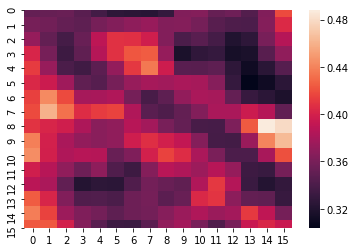

In [30]:
x = np.load("../data/train-super/136089019.npy")
sns.heatmap(x[12, :, :, 3])

In [31]:
import math
for i in os.listdir("../data/train-csv/"):
    if "subplot" in i and i[-4:] == ".csv":
        #if any(x in i for x in ["africa-west", "cameroon", "koure", "niger"]):
        download_plots("../data/train-csv/" + i, "../data/train-s2/")

STARTING DOWNLOAD OF 191 plots from ../data/train-csv/subplot4.csv to ../data/train-s2/
0 135345853
31.901853251005353 11.817597529111332
[480.0, 480.0]
31.90024300281474 11.81599049526655
[960.0, 960.0]
ERROR: Initial field greater than 130m
(67, 96, 96, 10)
0
[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  14.   0. 200.
   0.   0.   0.   0.   0.   0.   0. 602.  32.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   8.   0. 179.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
The shadow probability is: 0.07514510779436152
[  0.   0

[   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  669.    0.    0. 1253.   26.    0.    0.    0.    0.    0.  404.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.]
The shadow probability is: 0.7946987480438185
[   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 1664.    0.    0. 2656.   96.    0.    0.    0.    0.    0.  784.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.]
36.04777574694768 8.96510106419813
[500.0, 500.0]
(48, 48, 1)
Original size: (71, 49, 48

Interpolated 1962 px
Before super: (47, 32, 32, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
47/47 [==============================] - 1s 30ms/step
(47, 32, 32, 6)
(47, 32, 32, 11)
After super shape: (47, 16, 16, 11)
There are: 2 out of bounds EVI
()
evis error: -0.015628144145011902, 5.782320976257324, 1 steps, clipping to -1.5, 1.5
Clean: (47, 16, 16, 15)
There are 0 missing pixels
Maximum time distance: 33
(24, 16, 16, 15)


7 135345860
40.314119136867 14.944681202908205
[480.0, 480.0]
40.31245861142065 14.943088852706683
[960.0, 960.0]
ERROR: Initial field greater than 130m
(75, 96, 96, 10)
20
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

Interpolated 0 px
Before super: (55, 32, 32, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
55/55 [==============================] - 2s 30ms/step
(55, 32, 32, 6)
(55, 32, 32, 11)
After super shape: (55, 16, 16, 11)
There are: 0 out of bounds EVI
Clean: (55, 16, 16, 15)
There are 0 missing pixels
Maximum time distance: 30
(24, 16, 16, 15)


11 135345864
36.28732016207948 14.343803071958929
[480.0, 480.0]
36.28570692085003 14.342175756051866
[960.0, 960.0]
ERROR: Initial field greater than 130m
(73, 96, 96, 10)
53
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
The shadow pr

(74, 96, 96, 10)
22
[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0. 167.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.]
[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0. 143.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.]
The shadow probability is: 0.09853603603603604
[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.  

Interpolated 0 px
Before super: (64, 32, 32, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
64/64 [==============================] - 3s 44ms/step
(64, 32, 32, 6)
(64, 32, 32, 11)
After super shape: (64, 16, 16, 11)
There are: 0 out of bounds EVI
Clean: (64, 16, 16, 15)
There are 0 missing pixels
Maximum time distance: 25
(24, 16, 16, 15)


19 135345874
40.038892680283915 11.262865072672232
[480.0, 480.0]
40.03727027734861 11.261275249045719
[960.0, 960.0]
ERROR: Initial field greater than 130m
(73, 96, 96, 10)
13
[   0.    0.    0.  844.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.   17.    0.    0.    0.    0.    0.    0.   89.    0.
    0.    0.    0.    0.   24.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.  232.  535.    0.    0.    0.    0. 3975.
    0.    0.    0.    0.    0.  517.    0.  460.    0.    0.    0.    0.
    0.]
[   0.    0.  

[   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0. 1154.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.]
The shadow probability is: 0.33167495854063017
[   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0. 2048.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.]
34.405260558147184 13.364605827476094
[500.0, 500.0]
(48, 48, 1)
Original size: (67, 48, 48, 4)
[-15 -10  -5   0   5  10  15  20  30  3

(48, 48, 1)
Original size: (67, 48, 48, 4)
[-15 -10  -5   0   5  10  15  20  30  35  40  45  50  55  60  65  70  75
  80  85  90  95 105 110 115 120 125 130 135 140 150 160 165 170 185 195
 200 205 215 220 225 240 245 255 265 270 275 280 285 290 295 300 305 310
 315 320 325 335 340 345 350 355 360 365 370 375 380]
There are 8/67 dirty steps: 8 cloud, 0 missing, 0 shadow
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 27, 9, 21, 14, 10, 15, 9, 14, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Removing 3 steps based on ratio
Interpolated 517 px
Before super: (56, 32, 32, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
56/56 [==============================] - 2s 39ms/step
(56, 32, 32, 6)
(56, 32, 32, 11)
After super shape: (56, 16, 16, 11)
There are: 0 out of bounds EVI
Clean: (56, 16, 16, 15)
There are 0 missing pixels
Maximum time distance: 35
(24, 16, 16, 15)


26 135345884
36.80210990428362 11.412263529934

Interpolated 0 px
Before super: (65, 32, 32, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
65/65 [==============================] - 3s 40ms/step
(65, 32, 32, 6)
(65, 32, 32, 11)
After super shape: (65, 16, 16, 11)
There are: 0 out of bounds EVI
Clean: (65, 16, 16, 15)
There are 0 missing pixels
Maximum time distance: 22
(24, 16, 16, 15)


29 135345887
34.8635878560548 10.479092962645517
[480.0, 480.0]
34.861966803031684 10.477510483391319
[960.0, 960.0]
ERROR: Initial field greater than 130m
(69, 96, 96, 10)
68
[   0.  261.   73.    8.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.   39.   68.    0.
    0.    0.    0.    0.    0.   36.    0.    0.    0.    0.    0.    0.
 1260.   71.   55.    0. 1540.    0.    0.    0.    0.    0.    0.    0.
    0.  613.  553.    0.    0.    0.    0.    0.    0.]
[   0.    0.    0.    0.    0.    0.    

[ 0.  0. 16.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.]
The shadow probability is: 0.033602150537634407
[  0.   0. 192.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.]
33.38814795721091 12.132480097127264
[500.0, 500.0]
(48, 48, 1)
Original size: (62, 48, 48, 4)
[-12  -7  -2   3   8  13  18  23  28  33  38  48  53  58  63  68  73  78
  83  88  93  98 103 108 113 118 123 128 133 138 143 153 158 173 203 208
 213 218 223 228 243 253 258 268 283 288 298 303 308 313 318 323 333 338
 343 348 353 358 363 368 373 378]
There are 6/62 dirty steps: 6 cloud

(48, 48, 1)
Original size: (72, 48, 48, 4)
[-13  -8  -3   2  12  17  22  27  32  37  42  47  52  57  62  67  72  77
  82  87  92  97 102 107 112 117 122 127 132 137 142 147 152 157 162 167
 172 177 187 197 202 212 227 232 237 242 247 252 257 262 267 272 277 282
 287 292 297 302 307 312 317 322 332 337 342 347 352 357 362 367 372 377]
There are 24/72 dirty steps: 21 cloud, 6 missing, 4 shadow
[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 1, 1, 1, 6, 14, 10, 10, 10, 8, 7, 9, 10, 0, 0, 1, 0, 0, 0, 0, 0]
Removing 0 steps based on ratio
Interpolated 1519 px
Before super: (48, 32, 32, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
48/48 [==============================] - 2s 51ms/step
(48, 32, 32, 6)
(48, 32, 32, 11)
After super shape: (48, 16, 16, 11)
There are: 0 out of bounds EVI
Clean: (48, 16, 16, 15)
There are 0 missing pixels
Maximum time distance: 40
(24, 16, 16, 15)


36 135345897
35.134394250972804 13.094267811119751
[480.

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 15, 18, 35, 27, 16, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Removing 5 steps based on ratio
Interpolated 0 px
Before super: (55, 32, 32, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
55/55 [==============================] - 2s 36ms/step
(55, 32, 32, 6)
(55, 32, 32, 11)
After super shape: (55, 16, 16, 11)
There are: 0 out of bounds EVI
Clean: (55, 16, 16, 15)
There are 0 missing pixels
Maximum time distance: 35
(24, 16, 16, 15)


40 135345906
37.50748164306435 12.120798354484851
[480.0, 480.0]
37.505872699073485 12.119187715377516
[960.0, 960.0]
ERROR: Initial field greater than 130m
(72, 96, 96, 10)
44
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 

Interpolated 785 px
Before super: (66, 32, 32, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
66/66 [==============================] - 3s 42ms/step
(66, 32, 32, 6)
(66, 32, 32, 11)
After super shape: (66, 16, 16, 11)
There are: 0 out of bounds EVI
Clean: (66, 16, 16, 15)
There are 0 missing pixels
Maximum time distance: 0
(24, 16, 16, 15)


44 135345911
38.05922282805841 15.178125446632368
[480.0, 480.0]
38.057582386641734 15.176510082985752
[960.0, 960.0]
ERROR: Initial field greater than 130m
(74, 96, 96, 10)
9
[0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 2.448e+03 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 4.000e+00 0.0

(48, 48, 1)
Original size: (78, 49, 48, 4)
[-14  -9  -4   1   6  11  16  21  28  31  36  41  46  51  53  56  61  66
  71  76  81  83  86  91  96 101 106 111 116 121 126 131 136 141 146 151
 156 161 166 171 181 186 191 196 203 206 211 218 223 228 236 243 246 251
 256 261 266 271 281 288 291 296 301 306 311 316 321 326 333 336 341 346
 351 356 361 366 371 376]
There are 8/78 dirty steps: 8 cloud, 0 missing, 0 shadow
[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 27, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 19, 17, 16, 14, 14, 11, 9, 7, 6, 4]
Removing 4 steps based on ratio
Interpolated 259 px
Before super: (66, 32, 32, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
66/66 [==============================] - 3s 42ms/step
(66, 32, 32, 6)
(66, 32, 32, 11)
After super shape: (66, 16, 16, 11)
There are: 0 out of bounds EVI
Clean: (66, 16, 16, 15)
There are 0 missing pixels
Maximum time

[   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0. 2329.    0.    0.    0.    0.
  447.    0.    0.    0.  779.    0. 2353.    0.    0.    0.    0.  433.
  605.  332.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.]
The shadow probability is: 2.565586419753086
[   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0. 4480.    0.    0.    0.    0.
 1152.    0.    0.    0. 3168.    0. 4224.    0.    0.    0.    0. 1568.
 1728.  704.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.]
36.335656788430335 10.852106914434833
[500.0, 500.0]
(48, 48, 1)
Original siz

Interpolated 1086 px
Before super: (39, 32, 32, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
39/39 [==============================] - 1s 30ms/step
(39, 32, 32, 6)
(39, 32, 32, 11)
After super shape: (39, 16, 16, 11)
There are: 0 out of bounds EVI
Clean: (39, 16, 16, 15)
There are 0 missing pixels
Maximum time distance: 115
(24, 16, 16, 15)


55 135345923
37.13415241828754 10.842024687075359
[480.0, 480.0]
37.13255518968694 10.840415446339875
[960.0, 960.0]
ERROR: Initial field greater than 130m
(73, 96, 96, 10)
3
[0.000e+00 0.000e+00 3.170e+02 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 1.780e+02 0.000e+00 1.000e+00 9.300e+01 0.000e+00 0.000e+00
 0.000e+00 8.000e+00 0.000e+00 0.000e+00 9.460e+02 6.020e+02 7.870e+02
 0.000e+00 0.000e+00 0.000e+00 1.016e+03 5.190e+02 0.000e+00 1.474e+03
 2.486e+03 0.000e+00 1.980e+02 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 1.621e+03 9

Interpolated 184 px
Before super: (68, 32, 32, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
68/68 [==============================] - 3s 37ms/step
(68, 32, 32, 6)
(68, 32, 32, 11)
After super shape: (68, 16, 16, 11)
There are: 0 out of bounds EVI
Clean: (68, 16, 16, 15)
There are 0 missing pixels
Maximum time distance: 20
(24, 16, 16, 15)


59 135345930
36.20516449959052 15.495229715017338
[480.0, 480.0]
36.20354260389067 15.493596923564631
[960.0, 960.0]
ERROR: Initial field greater than 130m
(75, 96, 96, 10)
13
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.]

(24, 16, 16, 15)


63 135345934
40.18621754680697 11.21484727292044
[480.0, 480.0]
40.18459455282385 11.21325869959317
[960.0, 960.0]
ERROR: Initial field greater than 130m
(73, 96, 96, 10)
9
[   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.  964.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.  812.    0. 2414.    0.    0.    0.    0.
    0.]
[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. 941.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0. 705.   0.   0.   0.   0.
   0.  

(48, 48, 1)
Original size: (71, 49, 47, 4)
[-15 -10  -5   0   5  10  15  20  25  30  35  40  45  50  55  60  65  70
  75  80  85  90  95 100 105 110 115 120 125 130 135 140 150 160 165 170
 175 180 185 190 195 200 205 210 215 220 230 240 245 250 255 265 280 285
 290 295 300 305 315 320 325 335 340 345 350 355 360 365 370 375 380]
There are 13/71 dirty steps: 13 cloud, 1 missing, 0 shadow
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 10, 20, 27, 30, 24, 37, 41, 53, 43, 39, 5, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Removing 9 steps based on ratio
Interpolated 17 px
Before super: (49, 32, 32, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
49/49 [==============================] - 2s 37ms/step
(49, 32, 32, 6)
(49, 32, 32, 11)
After super shape: (49, 16, 16, 11)
There are: 0 out of bounds EVI
Clean: (49, 16, 16, 15)
There are 0 missing pixels
Maximum time distance: 110
(24, 16, 16, 15)


67 135345939
36.40432164678

(48, 48, 1)
Original size: (69, 48, 48, 4)
[-16  -6  -1   4   9  14  19  24  29  34  39  44  49  54  59  64  69  74
  79  84  89  99 104 109 124 129 134 139 144 149 154 159 164 169 174 179
 184 189 194 199 204 209 219 229 234 239 244 249 254 259 269 284 289 294
 299 304 309 314 319 334 339 344 349 354 359 364 369 374 379]
There are 21/69 dirty steps: 21 cloud, 4 missing, 0 shadow
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 4, 2, 2, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Removing 0 steps based on ratio
Interpolated 60 px
Before super: (48, 32, 32, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
48/48 [==============================] - 2s 37ms/step
(48, 32, 32, 6)
(48, 32, 32, 11)
After super shape: (48, 16, 16, 11)
There are: 0 out of bounds EVI
Clean: (48, 16, 16, 15)
There are 0 missing pixels
Maximum time distance: 50
(24, 16, 16, 15)


71 135345943
33.19299821808679 13.032909633377635
[480.0, 480.0]
33.19136699

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
The shadow probability is: 0.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
34.29330575068438 14.968260877129783
[500.0, 500.0]
(48, 48, 1)
Original size: (72, 48, 48, 4)
[-12  -7  -2   3   8  13  18  23  28  33  38  43  48  53  58  63  68  73
  78  83  88  93  98 103 108 113 118 123 128 133 138 143 148 158 163 173
 178 183 188 193 198 203 208 218 223 233 238 243 253 263 268 273 278 283
 288 298 303 308 313 318 323 328 333 338 343 348 353 358 363 368 373 378]
There are 8/72 dirty steps: 8 cloud, 0 missing, 0 shadow
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

(48, 48, 1)
Original size: (72, 48, 48, 4)
[-16  -6  -1   4   9  14  19  24  29  34  39  44  49  54  59  64  69  74
  79  84  89  94  99 104 109 119 124 129 134 139 144 149 154 159 164 169
 174 179 184 189 194 204 209 214 229 234 239 244 249 259 264 269 279 284
 289 294 299 304 309 314 319 324 334 339 344 349 354 359 364 369 374 379]
There are 36/72 dirty steps: 33 cloud, 8 missing, 4 shadow
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 2, 0, 6, 0, 0, 0, 0, 17, 0, 0, 0]
Removing 1 steps based on ratio
Interpolated 1213 px
Before super: (35, 32, 32, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
35/35 [==============================] - 2s 43ms/step
(35, 32, 32, 6)
(35, 32, 32, 11)
After super shape: (35, 16, 16, 11)
There are: 0 out of bounds EVI
Clean: (35, 16, 16, 15)
There are 0 missing pixels
Maximum time distance: 75
(24, 16, 16, 15)


78 135345953
37.762753256533685 9.689481023327223
[480.0, 480.0]
37.76115780573814 9.68787847823

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0.]
The shadow probability is: 0.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0.]
33.68967686792532 9.157325358499843
[500.0, 500.0]
(48, 48, 1)
Original size: (57, 48, 48, 4)
[-15 -10  -5   0   5  10  15  20  30  40  45  50  55  60  65  75  80  85
  90  95 100 105 110 115 120 130 135 140 150 160 170 175 200 205 215 220
 225 245 265 275 295 300 305 310 315 320 325 335 340 345 350 355 360 365
 370 375 380]
There are 21/57 dirty steps: 21 cloud, 1 missing, 0 shadow
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Removing 0 steps based on ratio
Interpolated 106 px
Before super: (36, 32, 32, 11)
Predicting using file: ../src/dsen2/model

Interpolated 444 px
Before super: (74, 32, 32, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
74/74 [==============================] - 2s 31ms/step
(74, 32, 32, 6)
(74, 32, 32, 11)
After super shape: (74, 16, 16, 11)
There are: 0 out of bounds EVI
Clean: (74, 16, 16, 15)
There are 0 missing pixels
Maximum time distance: 0
(24, 16, 16, 15)


85 135345964
36.38766703279299 11.867653755444259
[480.0, 480.0]
36.38607028809878 11.866036668711894
[960.0, 960.0]
ERROR: Initial field greater than 130m
(82, 96, 96, 10)
22
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. 18. 39.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. 16.  0.
  0.  0. 99.  5.  0.  0.  0.  0.  0.  0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

[   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  379.  749.
 5974.    0.    0.    0. 4985. 4365. 1242. 1377.    0. 1974.    0.   71.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0. 1005.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0. 1411.  419. 3106.  731.
  997.    0.    0.    0. 1461.    0.    0.    0.    0.    0.    0.    0.]
The shadow probability is: 7.267554012345679
[   0.    0.    0.    0.    0.    0.    0.    0.    0.    0. 1360. 1792.
 7008.    0.    0.    0. 6176. 5664. 3904. 3680.    0. 3488.    0.  288.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0. 2176.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0. 2304.  736. 4752. 1360.
 1584.    0.    0.    0. 1952.    0.    0.    0.    0.    0.    0.    0.]
39.158547583079034 12.122247816803581
[500.0, 500.0]
(48, 48, 1)
Original siz

(48, 48, 1)
Original size: (72, 49, 48, 4)
[-13  -8  -3   2  12  17  22  27  32  37  42  47  52  57  62  67  72  77
  82  87  92  97 102 107 112 117 122 127 132 137 142 147 152 157 162 167
 172 177 187 197 202 212 227 232 237 242 247 252 257 262 267 272 277 282
 287 292 297 302 307 312 317 322 332 337 342 347 352 357 362 367 372 377]
There are 14/72 dirty steps: 13 cloud, 2 missing, 1 shadow
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Removing 0 steps based on ratio
Interpolated 0 px
Before super: (58, 32, 32, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
58/58 [==============================] - 3s 44ms/step
(58, 32, 32, 6)
(58, 32, 32, 11)
After super shape: (58, 16, 16, 11)
There are: 0 out of bounds EVI
Clean: (58, 16, 16, 15)
There are 0 missing pixels
Maximum time distance: 20
(24, 16, 16, 15)


92 135345975
32.02860409752779 15.0

(48, 48, 1)
Original size: (74, 48, 48, 4)
[-15 -10  -5   0   5  10  15  20  25  30  35  40  45  50  55  60  65  70
  75  80  85  90  95 100 105 110 115 120 125 130 135 140 150 155 160 165
 170 175 185 190 195 200 205 210 215 220 240 245 250 255 260 265 270 275
 280 285 290 295 300 305 310 315 320 325 335 340 345 350 355 360 365 370
 375 380]
There are 4/74 dirty steps: 4 cloud, 0 missing, 1 shadow
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 43, 74, 73, 86, 69, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 4, 3]
Removing 5 steps based on ratio
Interpolated 0 px
Before super: (65, 32, 32, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
65/65 [==============================] - 3s 40ms/step
(65, 32, 32, 6)
(65, 32, 32, 11)
After super shape: (65, 16, 16, 11)
There are: 0 out of bounds EVI
Clean: (65, 16, 16, 15)
There are 0 missing pixels
Maximum time distance: 30
(24, 

Interpolated 0 px
Before super: (38, 32, 32, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
38/38 [==============================] - 2s 41ms/step
(38, 32, 32, 6)
(38, 32, 32, 11)
After super shape: (38, 16, 16, 11)
There are: 0 out of bounds EVI
Clean: (38, 16, 16, 15)
There are 0 missing pixels
Maximum time distance: 100
(24, 16, 16, 15)


99 135345986
32.408709755125486 14.017252276115928
[480.0, 480.0]
32.40707676528051 14.015643404478931
[960.0, 960.0]
ERROR: Initial field greater than 130m
(67, 96, 96, 10)
11
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
The shadow probability is: 0.0
[0. 0. 0. 0. 0. 0.

Interpolated 0 px
Before super: (50, 32, 32, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
50/50 [==============================] - 2s 40ms/step
(50, 32, 32, 6)
(50, 32, 32, 11)
After super shape: (50, 16, 16, 11)
There are: 0 out of bounds EVI
Clean: (50, 16, 16, 15)
There are 0 missing pixels
Maximum time distance: 50
(24, 16, 16, 15)


103 135345991
39.81432763965945 12.948798397685007
[480.0, 480.0]
39.8126920054297 12.947204320214425
[960.0, 960.0]
ERROR: Initial field greater than 130m
(72, 96, 96, 10)
15
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
The shadow probabilit

Interpolated 182 px
Before super: (55, 32, 32, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
55/55 [==============================] - 3s 51ms/step
(55, 32, 32, 6)
(55, 32, 32, 11)
After super shape: (55, 16, 16, 11)
There are: 0 out of bounds EVI
Clean: (55, 16, 16, 15)
There are 0 missing pixels
Maximum time distance: 50
(24, 16, 16, 15)


107 135345995
34.60240426234717 10.47683963187644
[480.0, 480.0]
34.600784740877685 10.475255054339055
[960.0, 960.0]
ERROR: Initial field greater than 130m
(62, 96, 96, 10)
61
[ 10. 359. 106.  17.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.  34.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  45.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 674. 200.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   4.  87.
   0.   0.   0.   0.   0.   0.]
[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.


Interpolated 456 px
Before super: (57, 32, 32, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
57/57 [==============================] - 4s 65ms/step
(57, 32, 32, 6)
(57, 32, 32, 11)
After super shape: (57, 16, 16, 11)
There are: 0 out of bounds EVI
Clean: (57, 16, 16, 15)
There are 0 missing pixels
Maximum time distance: 30
(24, 16, 16, 15)


111 135345999
38.29633653480808 14.180076050530367
[480.0, 480.0]
38.29470315357929 14.178465748143834
[960.0, 960.0]
ERROR: Initial field greater than 130m
(74, 96, 96, 10)
3
[   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0. 4090.    0.
 1877.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    7.    0.    0.  118. 4384.    0.    0.    0. 1418.    0.
    0. 1391.    0. 1515.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.]
[   0. 

CRITICAL:root:Failed to download from:
https://services.sentinel-hub.com/ogc/wcs/a14b8591-2127-4d2a-b5df-b47a9f2895e1?SERVICE=wcs&MAXCC=75.0&Downsampling=NEAREST&Upsampling=NEAREST&BBOX=14.178465748143834%2C38.29470315357929%2C14.182818559852823%2C38.29913776529787&FORMAT=image%2Ftiff%3Bdepth%3D32f&CRS=EPSG%3A4326&TIME=2019-12-06T08%3A06%3A04%2F2019-12-10T08%3A06%3A04&RESX=10m&RESY=10m&COVERAGE=L2A20&REQUEST=GetCoverage&VERSION=1.1.2
with HTTPError:
500 Server Error: Internal Server Error for url: https://services.sentinel-hub.com/ogc/wcs/a14b8591-2127-4d2a-b5df-b47a9f2895e1?SERVICE=wcs&MAXCC=75.0&Downsampling=NEAREST&Upsampling=NEAREST&BBOX=14.178465748143834%2C38.29470315357929%2C14.182818559852823%2C38.29913776529787&FORMAT=image%2Ftiff%3Bdepth%3D32f&CRS=EPSG%3A4326&TIME=2019-12-06T08%3A06%3A04%2F2019-12-10T08%3A06%3A04&RESX=10m&RESY=10m&COVERAGE=L2A20&REQUEST=GetCoverage&VERSION=1.1.2
Server response: "Out of retries"
Traceback (most recent call last):
  File "/Users/john.brandt/.l

'NoneType' object is not iterable
112 135346000
35.48268830446489 11.29329440116673
[480.0, 480.0]
35.48105651505671 11.29171693770659
[960.0, 960.0]
ERROR: Initial field greater than 130m


CRITICAL:root:Failed to download from:
https://services.sentinel-hub.com/ogc/wms/a14b8591-2127-4d2a-b5df-b47a9f2895e1?SERVICE=wms&MAXCC=75.0&Upsampling=NEAREST&BBOX=11.289566851588948%2C35.47884085480237%2C11.298167052953286%2C35.48770369342627&FORMAT=image%2Ftiff%3Bdepth%3D32f&CRS=EPSG%3A4326&TIME=2018-12-14T08%3A16%3A48%2F2018-12-18T08%3A16%3A48&WIDTH=96&HEIGHT=96&LAYERS=CLOUD_DETECTION&REQUEST=GetMap&VERSION=1.3.0
with HTTPError:
500 Server Error: Internal Server Error for url: https://services.sentinel-hub.com/ogc/wms/a14b8591-2127-4d2a-b5df-b47a9f2895e1?SERVICE=wms&MAXCC=75.0&Upsampling=NEAREST&BBOX=11.289566851588948%2C35.47884085480237%2C11.298167052953286%2C35.48770369342627&FORMAT=image%2Ftiff%3Bdepth%3D32f&CRS=EPSG%3A4326&TIME=2018-12-14T08%3A16%3A48%2F2018-12-18T08%3A16%3A48&WIDTH=96&HEIGHT=96&LAYERS=CLOUD_DETECTION&REQUEST=GetMap&VERSION=1.3.0
Server response: "Out of retries"
Traceback (most recent call last):
  File "/Users/john.brandt/.local/lib/python3.6/site-packages/s

Failed to download from:
https://services.sentinel-hub.com/ogc/wms/a14b8591-2127-4d2a-b5df-b47a9f2895e1?SERVICE=wms&MAXCC=75.0&Upsampling=NEAREST&BBOX=11.289566851588948%2C35.47884085480237%2C11.298167052953286%2C35.48770369342627&FORMAT=image%2Ftiff%3Bdepth%3D32f&CRS=EPSG%3A4326&TIME=2018-12-14T08%3A16%3A48%2F2018-12-18T08%3A16%3A48&WIDTH=96&HEIGHT=96&LAYERS=CLOUD_DETECTION&REQUEST=GetMap&VERSION=1.3.0
with HTTPError:
500 Server Error: Internal Server Error for url: https://services.sentinel-hub.com/ogc/wms/a14b8591-2127-4d2a-b5df-b47a9f2895e1?SERVICE=wms&MAXCC=75.0&Upsampling=NEAREST&BBOX=11.289566851588948%2C35.47884085480237%2C11.298167052953286%2C35.48770369342627&FORMAT=image%2Ftiff%3Bdepth%3D32f&CRS=EPSG%3A4326&TIME=2018-12-14T08%3A16%3A48%2F2018-12-18T08%3A16%3A48&WIDTH=96&HEIGHT=96&LAYERS=CLOUD_DETECTION&REQUEST=GetMap&VERSION=1.3.0
Server response: "Out of retries"
113 135346001
40.81130418788927 13.340723237163663
[480.0, 480.0]
40.80965681121436 13.339138103283084
[960.0, 9

(48, 48, 1)
Original size: (76, 48, 48, 4)
[-12  -7  -2   3   8  13  18  23  28  33  38  43  48  53  58  63  68  73
  78  83  88  93  98 103 108 113 118 123 128 133 138 143 148 153 158 163
 173 178 183 188 193 198 203 208 218 223 228 233 238 243 248 253 258 263
 268 273 278 283 288 298 303 308 313 318 323 328 333 338 343 348 353 358
 363 368 373 378]
There are 9/76 dirty steps: 9 cloud, 1 missing, 0 shadow
[0, 0, 0, 0, 0, 0, 0, 0, 11, 0, 0, 0, 0, 0, 0, 1, 1, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Removing 0 steps based on ratio
Interpolated 268 px
Before super: (67, 32, 32, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
67/67 [==============================] - 3s 38ms/step
(67, 32, 32, 6)
(67, 32, 32, 11)
After super shape: (67, 16, 16, 11)
There are: 0 out of bounds EVI
Clean: (67, 16, 16, 15)
There are 0 missing pixels
Maximum time distance: 0
(24, 16, 1

(74, 96, 96, 10)
22
[   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  210.    0.
   72.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0. 1046.    0.    0.    0.    0.    0.  144.    0.    0.
    0.    0.]
[   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  200.    0.
   72.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0. 1024.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.]
The shadow probability is: 0.45983483483483484
[   0.    0.    0.    0.    0

(48, 48, 1)
Original size: (77, 49, 47, 4)
[-15 -10  -5   0   5  10  15  20  25  30  35  40  45  50  55  60  65  67
  70  75  80  85  90  95 102 105 110 115 120 125 130 135 140 150 157 160
 165 170 175 180 185 190 195 202 205 215 220 225 237 240 252 255 260 265
 272 275 280 285 290 295 300 305 310 315 320 325 332 335 340 345 350 355
 360 365 370 375 380]
There are 26/77 dirty steps: 24 cloud, 2 missing, 2 shadow
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 41, 27, 26, 6, 6, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Removing 3 steps based on ratio
Interpolated 605 px
Before super: (48, 32, 32, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
48/48 [==============================] - 2s 38ms/step
(48, 32, 32, 6)
(48, 32, 32, 11)
After super shape: (48, 16, 16, 11)
There are: 0 out of bounds EVI
Clean: (48, 16, 16, 15)
There are 0 missing pixels
Maximum time distance: 90
(24, 16, 16, 15)


124 135346014
34.0431292044320

(72, 96, 96, 10)
71
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 29.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
The shadow probability is: 0.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
34.03745429101078 14.868164067048642
[500.0, 500.0]
(48, 48, 1)
Original size: (72, 48, 48, 4)
[-12  -7  -2   3   8  13  18  23  28  33  38  43  48  53  58  63  68  73
  78  83  88  93  98 103 108 113 118 123 128 133

67/67 [==============================] - 2s 32ms/step
(67, 32, 32, 6)
(67, 32, 32, 11)
After super shape: (67, 16, 16, 11)
There are: 0 out of bounds EVI
Clean: (67, 16, 16, 15)
There are 0 missing pixels
Maximum time distance: 35
(24, 16, 16, 15)


131 135346022
38.81472273092187 14.798774719911565
[480.0, 480.0]
38.813078167853824 14.797167536416737
[960.0, 960.0]
ERROR: Initial field greater than 130m
(74, 96, 96, 10)
3
[   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  782.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  821.
    0.  660.    0.    0.    0.    0. 1736.  926.    0.   29.    0.    0.
    0.    0.    0.    3.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.  487.    0.    0.    0.    0.
    0.    0.    0.    0.  368.    0.  657.   96.  349.    0.    0.   16.
    0.    0.]
[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0. 807.

(48, 48, 1)
Original size: (71, 49, 48, 4)
[-13  -8  -3   2   7  12  17  22  27  32  37  42  47  52  57  62  67  72
  77  82  87  92  97 102 107 117 122 127 132 137 142 147 157 162 172 177
 182 187 192 197 202 212 227 232 237 242 247 257 262 267 272 277 282 287
 292 297 302 307 317 322 327 332 337 342 347 352 357 362 367 372 377]
There are 21/71 dirty steps: 19 cloud, 4 missing, 4 shadow
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 17, 24, 13, 18, 2, 0, 1, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0]
Removing 3 steps based on ratio
Interpolated 514 px
Before super: (47, 32, 32, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
47/47 [==============================] - 2s 36ms/step
(47, 32, 32, 6)
(47, 32, 32, 11)
After super shape: (47, 16, 16, 11)
There are: 0 out of bounds EVI
Clean: (47, 16, 16, 15)
There are 0 missing pixels
Maximum time distance: 85
(24, 16, 16, 15)


135 135346027
37.245895439483775 15.675824567642643
[480.

[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   8.   0.   0. 251.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
The shadow probability is: 0.10467728758169935
[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. 656.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
35.563549940113845 10.83173321443578
[500.0, 500.0]
(48, 48, 1)
Original size: (68, 48, 48, 4)
[-15 -10  -5   0   5  10  15  20  25  30  35  40  45  50  55  60  65  70
  75  80  85  90  95 100 105 115 120 125 130 135 140 150 160 165 170 175
 180 185 195 205 215

Interpolated 1040 px
Before super: (58, 32, 32, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
58/58 [==============================] - 2s 31ms/step
(58, 32, 32, 6)
(58, 32, 32, 11)
After super shape: (58, 16, 16, 11)
There are: 0 out of bounds EVI
Clean: (58, 16, 16, 15)
There are 0 missing pixels
Maximum time distance: 20
(24, 16, 16, 15)


142 135346035
36.96531619843257 9.0512498618578
[480.0, 480.0]
36.96372985824653 9.04964493031461
[960.0, 960.0]
ERROR: Initial field greater than 130m
(67, 96, 96, 10)
14
[   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  431.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   36.
    0.    0.    0.  205.    0.    0.    0.    0.    0.    0.   59.   84.
    4.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 1938.    0.    0.    0.    0.    0.    0.]
[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   

(48, 48, 1)
Original size: (75, 48, 48, 4)
[-16  -6  -1   4   9  14  19  24  29  34  39  44  59  64  69  74  79  84
  89  94  99 104 109 114 119 124 129 134 139 144 149 154 159 164 169 174
 179 184 189 194 199 204 209 219 224 229 234 239 244 249 254 259 264 269
 279 284 289 294 299 304 309 314 319 324 329 334 339 344 349 354 359 364
 369 374 379]
There are 15/75 dirty steps: 15 cloud, 3 missing, 0 shadow
[3, 3, 3, 4, 4, 2, 73, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 2, 1, 1, 4, 3, 21]
Removing 2 steps based on ratio
Interpolated 84 px
Before super: (58, 32, 32, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
58/58 [==============================] - 2s 35ms/step
(58, 32, 32, 6)
(58, 32, 32, 11)
After super shape: (58, 16, 16, 11)
There are: 0 out of bounds EVI
Clean: (58, 16, 16, 15)
There are 0 missing pixels
Maximum time distance: 25
(24, 16, 16, 15)


146 135346040

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.]
The shadow probability is: 0.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.]
41.03560505718579 12.327367063903303
[500.0, 500.0]
(48, 48, 1)
Original size: (75, 48, 48, 4)
[-16  -6  -1   4   9  14  19  24  29  34  39  44  54  59  64  69  74  79
  84  89  94  99 104 109 114 119 124 129 134 139 144 149 154 159 164 169
 174 179 184 189 194 199 204 209 214 219 224 229 234 249 254 259 264 269
 279 284 289 294 299 304 309 314 319 324 329 334 339 344 349 354 359 364
 369 374 379]
There are 15/75 dirty steps: 15 cloud, 3 missing, 0 shadow
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
The shadow probability is: 0.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
32.323020527377885 11.52178194427323
[500.0, 500.0]
(48, 48, 1)
Original size: (58, 48, 48, 4)
[-12  -7  -2   3   8  13  18  23  28  33  38  48  53  58  63  68  73  78
  83  88  93  98 103 108 113 118 123 133 138 143 153 158 188 208 218 228
 233 243 253 268 283 288 298 303 308 313 318 323 333 338 343 348 353 358
 363 368 373 378]
There are 11/58 dirty steps: 11 cloud, 0 missing, 0 shadow
[1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Removing 0 steps based on ratio
Interpolated 0 px
Before super: (47, 32, 32, 11)

(48, 48, 1)
Original size: (67, 48, 48, 4)
[-12  -7  -2   3   8  13  18  23  28  33  38  43  48  53  58  63  68  73
  78  83  88  93  98 103 108 113 118 123 128 133 138 143 153 158 173 203
 208 213 218 223 228 233 238 243 253 258 263 268 283 288 298 303 308 313
 318 323 328 333 338 343 348 353 358 363 368 373 378]
There are 9/67 dirty steps: 9 cloud, 1 missing, 0 shadow
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Removing 0 steps based on ratio
Interpolated 0 px
Before super: (58, 32, 32, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
58/58 [==============================] - 2s 33ms/step
(58, 32, 32, 6)
(58, 32, 32, 11)
After super shape: (58, 16, 16, 11)
There are: 0 out of bounds EVI
Clean: (58, 16, 16, 15)
There are 0 missing pixels
Maximum time distance: 35
(24, 16, 16, 15)


158 135346058
40.13935790609222 13.784044157848609
[480.0

Interpolated 0 px
Before super: (52, 32, 32, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
52/52 [==============================] - 2s 32ms/step
(52, 32, 32, 6)
(52, 32, 32, 11)
After super shape: (52, 16, 16, 11)
There are: 0 out of bounds EVI
Clean: (52, 16, 16, 15)
There are 0 missing pixels
Maximum time distance: 55
(24, 16, 16, 15)


162 135346062
35.51218379582434 13.260859531042462
[480.0, 480.0]
35.51053206068566 13.25928157019778
[960.0, 960.0]
ERROR: Initial field greater than 130m
(70, 96, 96, 10)
69
[0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 2.530e+02 0.000e+00 0.000e+00 0.00

Interpolated 361 px
Before super: (61, 32, 32, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
61/61 [==============================] - 2s 33ms/step
(61, 32, 32, 6)
(61, 32, 32, 11)
After super shape: (61, 16, 16, 11)
There are: 0 out of bounds EVI
Clean: (61, 16, 16, 15)
There are 0 missing pixels
Maximum time distance: 25
(24, 16, 16, 15)


166 135346067
36.19877926462132 13.846050838131
[480.0, 480.0]
36.197170881338266 13.844424893547972
[960.0, 960.0]
ERROR: Initial field greater than 130m
(72, 96, 96, 10)
71
[0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 8.250e+02
 0.000e+00 0.000e+00 0.000e+00 6.6

The shadow probability is: 0.08333333333333333
[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0. 576.]
41.161423506728156 12.069406080696275
[500.0, 500.0]
(48, 48, 1)
Original size: (75, 48, 48, 4)
[-16  -6  -1   4   9  14  19  24  29  34  39  44  54  59  64  69  74  79
  84  89  94  99 104 109 114 119 124 129 134 139 144 149 154 159 164 169
 174 179 184 189 194 199 204 209 214 219 224 229 234 249 254 259 264 269
 279 284 289 294 299 304 309 314 319 324 329 334 339 344 349 354 359 364
 369 374 379]
There are 9/75 dirty steps: 9 cloud, 1 missing, 0 shadow
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Interpolated 0 px
Before super: (46, 32, 32, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
46/46 [==============================] - 2s 54ms/step
(46, 32, 32, 6)
(46, 32, 32, 11)
After super shape: (46, 16, 16, 11)
There are: 0 out of bounds EVI
Clean: (46, 16, 16, 15)
There are 0 missing pixels
Maximum time distance: 130
(24, 16, 16, 15)


173 135346079
39.66918652276434 10.85703855897305
[480.0, 480.0]
39.66756988524332 10.855446349730341
[960.0, 960.0]
ERROR: Initial field greater than 130m
(73, 96, 96, 10)
19
[   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.   29.    0.    0.    0. 1083.    0.    0. 3393.    0.    0. 1868.
  156.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0. 1349.    0. 2136.    0. 1581.    0.    0.
  344.    0.    0. 2422.  351.    0.    0.  252.    0.    0. 1221.    0.
  196.]
[   0.    0.  

/Users/john.brandt/.local/lib/python3.6/site-packages/ipykernel_launcher.py:70: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
/Users/john.brandt/.local/lib/python3.6/site-packages/ipykernel_launcher.py:72: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


[1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 0, 43, 0, 0, 0, 41, 0, 0, 0, 0, 0, 70, 0, 64, 0, 0, 0, 11, 0, 0, 0, 0, 100, 1, 0, 0, 1, 1, 33]
Removing 6 steps based on ratio


CRITICAL:root:index 39 is out of bounds for axis 0 with size 39
Traceback (most recent call last):
  File "<ipython-input-29-f66a3d4090c4>", line 88, in download_plots
    x = remove_cloud_and_shadows(tiles, probs, shadows, image_dates)
  File "<ipython-input-16-7b77f13d2939>", line 26, in remove_cloud_and_shadows
    aft = tiles[after, cval:cval+wsize, rval:rval+wsize, : ]
IndexError: index 39 is out of bounds for axis 0 with size 39


index 39 is out of bounds for axis 0 with size 39
174 135346081
33.07966373109314 10.827639148712803
[480.0, 480.0]
33.07805141656481 10.826042637094575
[960.0, 960.0]
ERROR: Initial field greater than 130m
(63, 96, 96, 10)
29
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
The shadow probability is: 0.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
33.07966373109314 10.827639148712803
[500.0, 500.0]
(48, 48, 1)
Original size: (63, 48, 48, 4)
[-12  -7  -2   3   8  13  18  23  28  33  38  48  53  58  63  68  73

45/45 [==============================] - 1s 31ms/step
(45, 32, 32, 6)
(45, 32, 32, 11)
After super shape: (45, 16, 16, 11)
There are: 0 out of bounds EVI
Clean: (45, 16, 16, 15)
There are 0 missing pixels
Maximum time distance: 90
(24, 16, 16, 15)


178 135346087
31.865514759931845 15.293147244586848
[480.0, 480.0]
31.863875311501864 15.291529725287331
[960.0, 960.0]
ERROR: Initial field greater than 130m
(75, 96, 96, 10)
7
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.]
The shadow probability is: 0.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0

Interpolated 426 px
Before super: (65, 32, 32, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
65/65 [==============================] - 2s 33ms/step
(65, 32, 32, 6)
(65, 32, 32, 11)
After super shape: (65, 16, 16, 11)
There are: 0 out of bounds EVI
Clean: (65, 16, 16, 15)
There are 0 missing pixels
Maximum time distance: 25
(24, 16, 16, 15)


182 135346092
35.95140380131767 12.718782409353741
[480.0, 480.0]
35.94975488788235 12.71720918063417
[960.0, 960.0]
ERROR: Initial field greater than 130m
(71, 96, 96, 10)
60
[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0. 578.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.]
[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0. 

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
The shadow probability is: 0.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
41.13344440539724 10.662635137797096
[500.0, 500.0]
(48, 48, 1)
Original size: (80, 48, 48, 4)
[-16  -9  -6  -1   4   9  14  19  24  29  34  39  44  49  54  59  64  69
  74  79  84  89  94  99 104 109 116 119 124 129 134 139 144 149 154 159
 164 169 174 179 184 189 194 199 204 209 216 219 224 229 234 241 244 249
 254 259 264 269 276 279 284 289 294 299 304 309 314 319 324 329 334 339
 344 349 354 359 364 369 374 379]
There are 12/80 dirty steps: 12 cloud, 2 missing, 0 shadow

(48, 48, 1)
Original size: (62, 48, 48, 4)
[-15 -10  -5   0   5  10  15  20  25  30  40  45  50  60  65  70  75  80
  85  90  95 105 115 120 125 130 135 140 150 160 170 175 205 215 220 240
 245 250 255 260 265 275 280 285 290 295 300 305 310 315 320 325 335 340
 345 350 355 360 365 370 375 380]
There are 20/62 dirty steps: 19 cloud, 1 missing, 0 shadow
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 96, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Removing 1 steps based on ratio
Interpolated 947 px
Before super: (41, 32, 32, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
41/41 [==============================] - 1s 36ms/step
(41, 32, 32, 6)
(41, 32, 32, 11)
After super shape: (41, 16, 16, 11)
There are: 0 out of bounds EVI
Clean: (41, 16, 16, 15)
There are 0 missing pixels
Maximum time distance: 70
(24, 16, 16, 15)


190 135346101
34.28789826358251 10.6344098849653
[480.0, 480.0]
34.28627937052359 10.632822698468177
[960.0, 960.0]
ERRO

[   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0. 1338.
 4415.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.   54.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.]
The shadow probability is: 1.337962962962963
[   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0. 2880.
 6112.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.  256.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.]
39.320605873865375 14.544826583292684
[

Interpolated 64 px
Before super: (65, 32, 32, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
65/65 [==============================] - 3s 41ms/step
(65, 32, 32, 6)
(65, 32, 32, 11)
After super shape: (65, 16, 16, 11)
There are: 0 out of bounds EVI
Clean: (65, 16, 16, 15)
There are 0 missing pixels
Maximum time distance: 30
(24, 16, 16, 15)


6 135191142
38.844030505002806 14.634251321537677
[480.0, 480.0]
38.842387299932774 14.632644829840688
[960.0, 960.0]
ERROR: Initial field greater than 130m
(74, 96, 96, 10)
3
[0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.580e+02 0.000e+00
 0.000e+00 4.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 3.968e+03 1.000e+00 0.000e+00 0.000e+00
 0.000e+00 1.134e+03 2.277e+03 2.490e+02 0.000e+00 1.320e+02 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 1.500e+01 8.0

(24, 16, 16, 15)


9 135191146
38.944644846441214 13.829828615589362
[480.0, 480.0]
38.94300848609906 13.828224977908448
[960.0, 960.0]
ERROR: Initial field greater than 130m
(74, 96, 96, 10)
69
[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. 113.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0. 71.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.]
The shadow probability is: 0.028153153153153154
[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.  

[   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  713.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  623. 2066.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.]
The shadow probability is: 0.853978978978979
[   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0. 1152.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 1280. 3392.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.]
38.80264291981152 14.823976484060045
[500.0, 500.0]

Interpolated 562 px
Before super: (50, 32, 32, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
50/50 [==============================] - 2s 36ms/step
(50, 32, 32, 6)
(50, 32, 32, 11)
After super shape: (50, 16, 16, 11)
There are: 0 out of bounds EVI
Clean: (50, 16, 16, 15)
There are 0 missing pixels
Maximum time distance: 20
(24, 16, 16, 15)


16 135191153
38.17482867281184 13.904764250174066
[480.0, 480.0]
38.17319900590162 13.903153659466525
[960.0, 960.0]
ERROR: Initial field greater than 130m
(74, 96, 96, 10)
66
[   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0. 1183.    0.
    0.    0.    0. 1301.   11.    0.    0.  193.   64.    0.    0.    4.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  404.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    3.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.]
[   0. 

There are 0 missing pixels
Maximum time distance: 30
(24, 16, 16, 15)


19 135191156
38.40143806332252 14.390547590836553
[480.0, 480.0]
38.39980165618771 14.388937646299041
[960.0, 960.0]
ERROR: Initial field greater than 130m
(76, 96, 96, 10)
60
[   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.  145.    0. 1069.    0.    0.    0.    0.
    0.    0.    0.    0.    0.  738.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.]
[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. 127.   0.   0.
   0

(48, 48, 1)
Original size: (79, 48, 48, 4)
[-16 -13  -8  -3   2   7  12  17  22  27  32  37  42  47  52  57  62  67
  72  77  82  87  92  97 102 107 112 117 122 127 132 137 142 147 154 157
 162 167 172 177 182 187 192 197 202 207 217 224 227 232 237 242 247 252
 257 262 267 272 277 282 287 294 297 302 307 312 317 322 327 332 337 342
 347 352 357 362 367 372 377]
There are 19/79 dirty steps: 18 cloud, 2 missing, 1 shadow
[1, 2, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 15, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 15, 0, 0, 0, 0, 0, 1, 2, 1, 1, 1, 1, 1, 0, 1]
Removing 2 steps based on ratio
Interpolated 1069 px
Before super: (58, 32, 32, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
58/58 [==============================] - 2s 34ms/step
(58, 32, 32, 6)
(58, 32, 32, 11)
After super shape: (58, 16, 16, 11)
There are: 0 out of bounds EVI
Clean: (58, 16, 16, 15)
There are 0 missing pixels
Maximum time distance: 25
(24, 16, 16, 1

66/66 [==============================] - 3s 52ms/step
(66, 32, 32, 6)
(66, 32, 32, 11)
After super shape: (66, 16, 16, 11)
There are: 0 out of bounds EVI
Clean: (66, 16, 16, 15)
There are 0 missing pixels
Maximum time distance: 40
(24, 16, 16, 15)


26 135191163
38.91462137798772 13.830890438094752
[480.0, 480.0]
38.91298528725115 13.829286527555507
[960.0, 960.0]
ERROR: Initial field greater than 130m
(74, 96, 96, 10)
73
[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.  50.   0.   4.   0.   0.  13.   0.   0.   0.   0.   0.   0.   0.
   0.   0. 638.   0.   0.   0.   0.   0.   0.  11.   0. 572. 293.   1.
 227.   0.   0.   0.   0.   4.   0. 130.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.]
[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.  28.   0.   0.   0.   0.   0.   0.   0.   0.   0.

(75, 96, 96, 10)
10
[   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   31.    0.    0.    0.    0.    0.    0. 2171.    0.   10.    0.    0.
    0.    0.    0.    0.    3.    0.    0.    0.    0.    3.    0.    0.
    0.    0.    0.]
[   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   16.    0.    0.    0.    0.    0.    0. 2160.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.]
The shadow probability is: 0.5231481481481481
[   0.    0.    0.

[   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  814.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.  668.    0.    0. 1123.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.   32.    0.    0.  578.
    0.    0.    0.    0.]
The shadow probability is: 1.0393823099415205
[   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0. 1696.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0. 1344.    0.    0. 3104.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.  128.    0.    0. 1008.
    0.    0.    0.    0.]
39.20468289536575 13.66510

(48, 48, 1)
Original size: (76, 48, 48, 4)
[-13  -8  -3   2   7  12  17  22  27  32  37  42  47  52  57  62  67  72
  77  82  87  92  97 102 107 112 117 122 127 132 137 142 147 157 162 167
 172 177 182 187 192 197 202 207 217 224 227 232 237 242 247 252 257 262
 267 272 277 282 287 297 302 307 312 317 322 327 332 337 342 347 352 357
 362 367 372 377]
There are 15/76 dirty steps: 12 cloud, 1 missing, 2 shadow
[0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 1, 36, 2, 0, 29, 0, 0, 0, 0, 0, 55, 0, 0, 0, 0, 7, 0, 2, 0, 0, 0]
Removing 3 steps based on ratio
Interpolated 474 px
Before super: (58, 32, 32, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
58/58 [==============================] - 2s 42ms/step
(58, 32, 32, 6)
(58, 32, 32, 11)
After super shape: (58, 16, 16, 11)
There are: 0 out of bounds EVI
Clean: (58, 16, 16, 15)
There are 0 missing pixels
Maximum time distance: 25
(24, 16, 16, 15)


36 1

(48, 48, 1)
Original size: (76, 48, 48, 4)
[-13  -8  -3   2   7  12  17  22  27  32  37  42  47  52  57  62  67  72
  77  82  87  92  97 102 107 112 117 122 127 132 137 142 147 152 157 162
 167 172 177 182 187 192 197 202 207 227 232 237 242 247 252 257 262 267
 272 277 282 287 292 297 302 307 312 317 322 327 332 337 342 347 352 357
 362 367 372 377]
There are 17/76 dirty steps: 16 cloud, 3 missing, 1 shadow
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 8, 9, 3, 1, 0, 0, 0, 0, 41, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Removing 1 steps based on ratio
Interpolated 332 px
Before super: (58, 32, 32, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
58/58 [==============================] - 2s 43ms/step
(58, 32, 32, 6)
(58, 32, 32, 11)
After super shape: (58, 16, 16, 11)
There are: 0 out of bounds EVI
Clean: (58, 16, 16, 15)
There are 0 missing pixels
Maximum time distance: 40
(24, 16, 16, 15)


39 135191176

Interpolated 260 px
Before super: (63, 32, 32, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
63/63 [==============================] - 4s 59ms/step
(63, 32, 32, 6)
(63, 32, 32, 11)
After super shape: (63, 16, 16, 11)
There are: 0 out of bounds EVI
Clean: (63, 16, 16, 15)
There are 0 missing pixels
Maximum time distance: 30
(24, 16, 16, 15)


42 135191181
39.112784990174475 13.64445430847296
[480.0, 480.0]
39.11114883438001 13.642852598938493
[960.0, 960.0]
ERROR: Initial field greater than 130m
(69, 96, 96, 10)
13
[0.000e+00 1.080e+02 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 5.374e+03 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 6.350e+02 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 2.890e+02 1.028e+03 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.040e+02 2.540e+02 0.000e+00
 5.000e+00 0.000e+00 0.000e+00 6.880e+02 0.000e+00 0.000e+00 2.199e+03
 0.000e+00 0.000e+00 1.170e+02 4.

Interpolated 404 px
Before super: (62, 32, 32, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
62/62 [==============================] - 2s 32ms/step
(62, 32, 32, 6)
(62, 32, 32, 11)
After super shape: (62, 16, 16, 11)
There are: 0 out of bounds EVI
Clean: (62, 16, 16, 15)
There are 0 missing pixels
Maximum time distance: 35
(24, 16, 16, 15)


45 135191184
39.24317775957472 13.89989676388033
[480.0, 480.0]
39.24153797434377 13.898295699670026
[960.0, 960.0]
ERROR: Initial field greater than 130m
(76, 96, 96, 10)
7
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 37.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. 19.  0.  0.  0. 10.
  0.  0. 26.  0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0

(48, 48, 1)
Original size: (74, 48, 48, 4)
[-13  -8  -3   2  12  17  22  27  32  37  42  47  52  57  62  67  72  77
  82  87  92  97 102 107 112 117 122 127 132 137 142 147 152 157 162 167
 172 177 182 187 192 197 202 207 227 232 237 242 247 252 257 262 267 272
 277 282 287 297 302 307 312 317 322 327 332 337 342 347 352 357 362 367
 372 377]
There are 16/74 dirty steps: 14 cloud, 6 missing, 2 shadow
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 3, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 1, 2, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 8, 57, 15, 33, 0, 0, 0, 0, 0, 0, 0, 0]
Removing 3 steps based on ratio
Interpolated 419 px
Before super: (55, 32, 32, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
55/55 [==============================] - 2s 39ms/step
(55, 32, 32, 6)
(55, 32, 32, 11)
After super shape: (55, 16, 16, 11)
There are: 0 out of bounds EVI
Clean: (55, 16, 16, 15)
There are 0 missing pixels
Maximum time distance: 30
(24, 16, 16, 15)


49 135191188
38.68121

Interpolated 349 px
Before super: (63, 32, 32, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
63/63 [==============================] - 2s 38ms/step
(63, 32, 32, 6)
(63, 32, 32, 11)
After super shape: (63, 16, 16, 11)
There are: 0 out of bounds EVI
Clean: (63, 16, 16, 15)
There are 0 missing pixels
Maximum time distance: 40
(24, 16, 16, 15)


52 135191191
37.88986666161275 14.113150051716381
[480.0, 480.0]
37.8882379949742 14.111536426122196
[960.0, 960.0]
ERROR: Initial field greater than 130m
(76, 96, 96, 10)
3
[0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.00

[   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.  268.    0.    0.    0.    0.    0.    0.    0.    0.    0.   16.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.  371.    0.    0.    0.    0.    0.    0.    0.   13.    0.    0.
    0. 1486.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.]
The shadow probability is: 0.8878340365682138
[   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.  896.    0.    0.    0.    0.    0.    0.    0.    0.    0.  128.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0. 1792.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0. 3648.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    

(48, 48, 1)
Original size: (76, 48, 48, 4)
[-13  -8  -3   2   7  12  17  22  27  32  37  42  47  52  57  62  67  72
  77  82  87  92  97 102 107 112 117 122 127 132 137 142 147 152 157 162
 167 172 177 182 187 192 197 202 207 227 232 237 242 247 252 257 262 267
 272 277 282 287 292 297 302 307 312 317 322 327 332 337 342 347 352 357
 362 367 372 377]
There are 17/76 dirty steps: 16 cloud, 3 missing, 1 shadow
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 28, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 12, 0, 0, 17, 13, 28, 53, 14, 13, 1, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Removing 4 steps based on ratio
Interpolated 981 px
Before super: (55, 32, 32, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
55/55 [==============================] - 2s 34ms/step
(55, 32, 32, 6)
(55, 32, 32, 11)
After super shape: (55, 16, 16, 11)
There are: 0 out of bounds EVI
Clean: (55, 16, 16, 15)
There are 0 missing pixels
Maximum time distance: 80
(24, 16, 16, 15)


59 1

(48, 48, 1)
Original size: (79, 48, 48, 4)
[-16 -13  -8  -3   2   7  12  17  22  27  32  37  42  47  52  57  62  67
  72  77  82  87  92  97 102 107 112 117 122 127 132 137 142 147 154 157
 162 167 172 177 182 187 192 197 202 207 217 224 227 232 237 242 247 252
 257 262 267 272 277 282 287 294 297 302 307 312 317 322 327 332 337 342
 347 352 357 362 367 372 377]
There are 24/79 dirty steps: 24 cloud, 3 missing, 1 shadow
[6, 18, 9, 6, 8, 9, 7, 3, 3, 2, 2, 1, 1, 2, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 18, 5, 36, 18, 12, 15, 11, 10]
Removing 5 steps based on ratio
Interpolated 0 px
Before super: (50, 32, 32, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
50/50 [==============================] - 3s 51ms/step
(50, 32, 32, 6)
(50, 32, 32, 11)
After super shape: (50, 16, 16, 11)
There are: 0 out of bounds EVI
Clean: (50, 16, 16, 15)
There are 0 missing pixels
Maximum time distance: 30
(24, 16, 16, 15)


62 1351

Interpolated 340 px
Before super: (51, 32, 32, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
51/51 [==============================] - 2s 37ms/step
(51, 32, 32, 6)
(51, 32, 32, 11)
After super shape: (51, 16, 16, 11)
There are: 0 out of bounds EVI
Clean: (51, 16, 16, 15)
There are 0 missing pixels
Maximum time distance: 65
(24, 16, 16, 15)


65 135191210
39.577316796954506 14.522552549684633
[480.0, 480.0]
39.575667658890445 14.520953401289416
[960.0, 960.0]
ERROR: Initial field greater than 130m
(79, 96, 96, 10)
62
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  7.  0.  0.  0.  0.  0.  0. 18.  0.  0. 35.
  0.  0.  0.  0.  0.  0.  0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

(48, 48, 1)
Original size: (76, 48, 48, 4)
[-13  -8  -3   2   7  12  17  22  27  32  37  42  47  52  57  62  67  72
  77  82  87  92  97 102 107 112 117 122 127 132 137 142 147 152 157 162
 167 172 177 182 187 192 197 202 207 227 232 237 242 247 252 257 262 267
 272 277 282 287 292 297 302 307 312 317 322 327 332 337 342 347 352 357
 362 367 372 377]
There are 15/76 dirty steps: 14 cloud, 0 missing, 2 shadow
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 17, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 3, 6, 8, 11, 58, 0, 1, 3, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Removing 2 steps based on ratio
Interpolated 941 px
Before super: (59, 32, 32, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
59/59 [==============================] - 2s 40ms/step
(59, 32, 32, 6)
(59, 32, 32, 11)
After super shape: (59, 16, 16, 11)
There are: 0 out of bounds EVI
Clean: (59, 16, 16, 15)
There are 0 missing pixels
Maximum time distance: 35
(24, 16, 16, 15)


69 1

(24, 16, 16, 15)


72 135191220
39.4329487589846 13.72915829764365
[480.0, 480.0]
39.431308918134995 13.727559340638702
[960.0, 960.0]
ERROR: Initial field greater than 130m
(76, 96, 96, 10)
9
[  14.   14.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    9.    0.    0.    0.    0.    0.    0.   83.    0.    0.
    0.   10.    0.    0.    0.    0.    0.    0. 1023.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    3.    0.    0.    0.    0.    0.    0. 1335.    0.    0.    0.
    0.   59.    0.    0.    7.    0.    0.  599.  171.    0.    6.    0.
    0.   11.   33.    0.]
[   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.   81.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.  951.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0. 13

(74, 96, 96, 10)
1
[6.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 5.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.700e+01 0.000e+00 3.700e+01
 2.000e+00 0.000e+00 0.000e+00 1.700e+02 0.000e+00 0.000e+00 4.100e+01
 0.000e+00 2.310e+02 6.460e+02 1.250e+02 0.000e+00 1.100e+01 0.000e+00
 1.438e+03 0.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 4.620e+02
 0.000e+00 3.730e+02 1.587e+03 2.420e+02 9.200e+01 1.226e+03 0.000e+00
 0.000e+00 7.710e+02 2.730e+02 1.040e+02 6.000e+01 0.000e+00 4.900e+01
 0.000e+00 8.000e+01 0.000e+00 0.000e+00 3.700e+01 5.700e+01 2.400e+01
 4.000e+00 0.000e+00 0.000e+00 0.000e+00]
[   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.  141.    0.    0.   30.    0.    0.  638.
   14.    0.    0.    0. 1416.    0.    0.    0.    0.    0.    0.    0.
    0.    

(76, 96, 96, 10)
71
[   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.  108.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0. 1055.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  100.    0.    0.    0.    0.    0.   78.    0.    0.    0.    0.    0.
  157.    0.    0.    0.    0.   38.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.]
[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  78.   0.
   0.   0.   0.   0. 133.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.]
The shadow probability is: 0.13249269005847952
[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0. 

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
The shadow probability is: 0.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
38.58962525750049 14.715619145914642
[500.0, 500.0]
(48, 48, 1)
Original size: (74, 48, 48, 4)
[-13  -8  -3   2   7  12  17  22  27  32  37  42  47  52  57  62  67  72
  77  82  87  92  97 102 107 112 117 122 127 132 137 147 157 162 167 172
 177 182 187 192 197 202 207 227 232 237 242 247 252 257 262 267 272 277
 282 287 292 297 302 307 312 317 322 327 332 337 342 347 352 357 362 367
 372 377]
There are 11/74 dirty steps: 11 cloud, 1 missing, 0 shadow
[2, 2, 2, 2, 4, 2, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

(48, 48, 1)
Original size: (74, 48, 48, 4)
[-13  -8  -3   2  12  17  22  27  32  37  42  47  52  57  62  67  72  77
  82  87  92  97 102 107 112 117 122 127 132 137 142 147 152 157 162 167
 172 177 182 187 192 197 202 207 227 232 237 242 247 252 257 262 267 272
 277 282 287 297 302 307 312 317 322 327 332 337 342 347 352 357 362 367
 372 377]
There are 14/74 dirty steps: 14 cloud, 2 missing, 0 shadow
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 26, 7, 19, 25, 20, 65, 12, 27, 11, 25, 5, 6, 6, 1, 0, 36, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Removing 8 steps based on ratio
Interpolated 29 px
Before super: (52, 32, 32, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
52/52 [==============================] - 2s 38ms/step
(52, 32, 32, 6)
(52, 32, 32, 11)
After super shape: (52, 16, 16, 11)
There are: 0 out of bounds EVI
Clean: (52, 16, 16, 15)
There are 0 missing pixels
Maximum time distance: 45
(24, 16, 16, 15)


85 135191

(24, 16, 16, 15)


88 135191236
39.706322174633996 13.633589898713913
[480.0, 480.0]
39.70468086841485 13.631993672761165
[960.0, 960.0]
ERROR: Initial field greater than 130m
(74, 96, 96, 10)
0
[0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 4.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 3.200e+02 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 2.468e+03 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 1.425e+03 0.000e+00 0.000e+00 0.000e+00 3.770e+02 1.640e+02
 0.000e+00 0.000e+00 0.000e+00 1.060e+02 0.000e+00 0.000e+00 1.000e+01
 0.000e+00 1.270e+02 8.630e+02 0.000e+00 0.000e+00 2.000e+00 0.000e+00
 3.330e+02 0.000e+00 0.000e+00 0.000e+00]
[   0.    0.    0.    0.    0.    0.    0.    0.    0

(74, 96, 96, 10)
57
[  0.   0.   0.   4.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 191.   0.   1.   0.   0.   0.   0.   0.   0.   0.  36.   0.   0.   0.
   0. 265.   0.   0.]
[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 168.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0. 234.   0.   0.]
The shadow probability is: 0.2393018018018018
[   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    

(24, 16, 16, 15)


94 135191244
38.60155383695616 14.04573757383881
[480.0, 480.0]
38.59991870378179 14.044130335108672
[960.0, 960.0]
ERROR: Initial field greater than 130m
(74, 96, 96, 10)
32
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. 48.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0. 36.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. 44.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.]
The shadow probability is: 0.03753753753753754
[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 256.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   

(48, 48, 1)
Original size: (74, 48, 48, 4)
[-16  -6  -1   4   9  14  19  24  29  34  39  44  49  54  59  64  69  74
  79  84  89  94  99 104 109 114 119 124 129 134 139 144 149 154 159 164
 169 174 179 184 189 194 199 204 224 229 234 239 244 249 259 264 269 279
 284 289 294 299 304 309 314 319 324 329 334 339 344 349 354 359 364 369
 374 379]
There are 28/74 dirty steps: 28 cloud, 7 missing, 0 shadow
[2, 2, 4, 3, 3, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 0, 4, 1, 1, 11]
Removing 0 steps based on ratio
Interpolated 743 px
Before super: (46, 32, 32, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
46/46 [==============================] - 2s 38ms/step
(46, 32, 32, 6)
(46, 32, 32, 11)
After super shape: (46, 16, 16, 11)
There are: 0 out of bounds EVI
Clean: (46, 16, 16, 15)
There are 0 missing pixels
Maximum time distance: 20
(24, 16, 16, 15)


98 135191249
38.46086411581559 14.045951887377694
[480.0, 4

(48, 48, 1)
Original size: (76, 48, 48, 4)
[-16 -13  -8  -3   2   9  12  17  22  27  32  37  42  47  52  57  62  67
  72  77  82  87  92  97 102 107 112 117 122 127 134 139 142 147 152 157
 162 167 172 177 182 187 192 197 202 224 227 232 237 242 247 257 262 267
 272 277 282 287 294 297 302 307 312 317 324 327 332 337 342 347 352 357
 362 367 372 377]
There are 14/76 dirty steps: 14 cloud, 2 missing, 1 shadow
[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 2, 4, 0, 0, 0, 0, 0, 13, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Removing 0 steps based on ratio
Interpolated 836 px
Before super: (62, 32, 32, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
62/62 [==============================] - 5s 75ms/step
(62, 32, 32, 6)
(62, 32, 32, 11)
After super shape: (62, 16, 16, 11)
There are: 0 out of bounds EVI
Clean: (62, 16, 16, 15)
There are 0 missing pixels
Maximum time distance: 55
(24, 16, 16, 15)


1

(48, 48, 1)
Original size: (76, 48, 48, 4)
[-16 -13  -8  -3   2   9  12  17  22  27  32  37  42  47  52  57  62  67
  72  77  82  87  92  97 102 107 112 117 122 127 134 139 142 147 152 157
 162 167 172 177 182 187 192 197 202 224 227 232 237 242 247 257 262 267
 272 277 282 287 294 297 302 307 312 317 324 327 332 337 342 347 352 357
 362 367 372 377]
There are 20/76 dirty steps: 20 cloud, 2 missing, 0 shadow
[5, 5, 4, 4, 4, 4, 5, 4, 4, 4, 4, 3, 4, 3, 4, 3, 3, 3, 3, 3, 2, 10, 3, 1, 1, 1, 9, 1, 1, 0, 1, 0, 0, 0, 22, 2, 1, 4, 0, 6, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
Removing 1 steps based on ratio
Interpolated 371 px
Before super: (55, 32, 32, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
55/55 [==============================] - 3s 48ms/step
(55, 32, 32, 6)
(55, 32, 32, 11)
After super shape: (55, 16, 16, 11)
There are: 0 out of bounds EVI
Clean: (55, 16, 16, 15)
There are 0 missing pixels
Maximum time distance: 50
(24, 16, 16, 15)


104 135191256
38.021

[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0. 553.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.]
The shadow probability is: 0.32845345345345345
[   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0. 2240.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.]
38.189803659281246 14.605785312369767
[500.0, 500.0]
(48, 48, 1)
Original size: (74, 48, 48, 4)
[-13  -8  -3   2   7  12  17

Interpolated 386 px
Before super: (64, 32, 32, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
64/64 [==============================] - 2s 37ms/step
(64, 32, 32, 6)
(64, 32, 32, 11)
After super shape: (64, 16, 16, 11)
There are: 0 out of bounds EVI
Clean: (64, 16, 16, 15)
There are 0 missing pixels
Maximum time distance: 35
(24, 16, 16, 15)


111 135191264
39.86604178479746 13.812905303116024
[480.0, 480.0]
39.86439731254804 13.811310283840788
[960.0, 960.0]
ERROR: Initial field greater than 130m
(74, 96, 96, 10)
9
[ 0.  0.  0. 15.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  2.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0

(48, 48, 1)
Original size: (74, 48, 48, 4)
[-13  -8  -3   2  12  17  22  27  32  37  42  47  52  57  62  67  72  77
  82  87  92  97 102 107 112 117 122 127 132 137 142 147 152 157 162 167
 172 177 182 187 192 197 202 207 227 232 237 242 247 252 257 262 267 272
 277 282 287 297 302 307 312 317 322 327 332 337 342 347 352 357 362 367
 372 377]
There are 8/74 dirty steps: 8 cloud, 1 missing, 0 shadow
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 2, 2, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Removing 0 steps based on ratio
Interpolated 461 px
Before super: (66, 32, 32, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
66/66 [==============================] - 6s 91ms/step
(66, 32, 32, 6)
(66, 32, 32, 11)
After super shape: (66, 16, 16, 11)
There are: 0 out of bounds EVI
Clean: (66, 16, 16, 15)
There are 0 missing pixels
Maximum time distance: 25
(24, 16, 16, 15)


11

Interpolated 713 px
Before super: (62, 32, 32, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
62/62 [==============================] - 3s 49ms/step
(62, 32, 32, 6)
(62, 32, 32, 11)
After super shape: (62, 16, 16, 11)
There are: 0 out of bounds EVI
Clean: (62, 16, 16, 15)
There are 0 missing pixels
Maximum time distance: 30
(24, 16, 16, 15)


118 135191275
38.497822200177204 14.52706031579757
[480.0, 480.0]
38.496183514796584 14.525450876994393
[960.0, 960.0]
ERROR: Initial field greater than 130m
(74, 96, 96, 10)
70
[0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 1.267e+03 0.000e+00 0.000e+00 0.000e+00 7.800e+01
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 

(24, 16, 16, 15)


121 135191281
39.24766174433727 14.431653345934649
[480.0, 480.0]
39.24601664941846 14.430051177118354
[960.0, 960.0]
ERROR: Initial field greater than 130m
(76, 96, 96, 10)
18
[   0.   72.   71.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0. 3401.    0.    0.    0.    0.
  734.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0. 1599.    0.
    0.    0.   86.   11.    0.  321.    0.  132.   95.   68.  169.  134.
    0.  126.  165.    0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0. 43.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.]
The shadow probability is: 0.0

Interpolated 239 px
Before super: (58, 32, 32, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
58/58 [==============================] - 2s 38ms/step
(58, 32, 32, 6)
(58, 32, 32, 11)
After super shape: (58, 16, 16, 11)
There are: 0 out of bounds EVI
Clean: (58, 16, 16, 15)
There are 0 missing pixels
Maximum time distance: 70
(24, 16, 16, 15)


125 135191290
38.862256616759076 14.726216126059454
[480.0, 480.0]
38.86061230824428 14.724609578479358
[960.0, 960.0]
ERROR: Initial field greater than 130m
(74, 96, 96, 10)
51
[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.  12.   8.   0.   5. 245.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0. 209.   0.   0.  65.   0.   0.   0.   0.   0.
   0.   0.   0.   0.]
[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0

[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0. 270.  14.   9.  19.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.  16.   0.   0.   0.  91.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.]
The shadow probability is: 0.2393018018018018
[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0. 832.   0.   0. 256.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0. 128.   0.   0.   0. 416.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.]
38.39526016391768 14.165385604180168
[500.0, 500.0]
(48, 48, 1)
Original size: (74, 48, 48, 4)
[-13  -8  -3   2  12  17  22  27  32  37  42  47  52  57  62  67  72  77
  82  87  92  97 102 107 112 117

Interpolated 756 px
Before super: (57, 32, 32, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
57/57 [==============================] - 2s 38ms/step
(57, 32, 32, 6)
(57, 32, 32, 11)
After super shape: (57, 16, 16, 11)
There are: 0 out of bounds EVI
Clean: (57, 16, 16, 15)
There are 0 missing pixels
Maximum time distance: 40
(24, 16, 16, 15)


132 135191298
38.43158049333004 13.812678216913357
[480.0, 480.0]
38.42994915111457 13.811070085887286
[960.0, 960.0]
ERROR: Initial field greater than 130m
(74, 96, 96, 10)
3
[0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 3.900e+01 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 2.190e+02 0.

(48, 48, 1)
Original size: (74, 48, 48, 4)
[-16  -6  -1   4   9  14  19  24  29  34  39  44  49  54  59  64  69  74
  79  84  89  94  99 104 109 114 119 124 129 134 139 144 149 154 159 164
 169 174 179 184 189 194 199 204 224 229 234 239 244 249 259 264 269 279
 284 289 294 299 304 309 314 319 324 329 334 339 344 349 354 359 364 369
 374 379]
There are 17/74 dirty steps: 17 cloud, 2 missing, 0 shadow
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Removing 0 steps based on ratio
Interpolated 0 px
Before super: (57, 32, 32, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
57/57 [==============================] - 2s 41ms/step
(57, 32, 32, 6)
(57, 32, 32, 11)
After super shape: (57, 16, 16, 11)
There are: 0 out of bounds EVI
Clean: (57, 16, 16, 15)
There are 0 missing pixels
Maximum time distance: 55
(24, 16, 16, 15)


139 135191310
37.966970480164

CRITICAL:root:index 52 is out of bounds for axis 0 with size 52
Traceback (most recent call last):
  File "<ipython-input-29-f66a3d4090c4>", line 88, in download_plots
    x = remove_cloud_and_shadows(tiles, probs, shadows, image_dates)
  File "<ipython-input-16-7b77f13d2939>", line 26, in remove_cloud_and_shadows
    aft = tiles[after, cval:cval+wsize, rval:rval+wsize, : ]
IndexError: index 52 is out of bounds for axis 0 with size 52


Original size: (78, 48, 48, 4)
[-16 -13  -8  -3   2   7  12  17  22  27  32  37  42  47  52  57  62  67
  72  77  82  87  92  97 102 107 112 117 122 127 132 142 147 154 157 162
 167 172 177 182 187 192 197 202 207 217 224 227 232 237 242 247 252 257
 262 267 272 277 282 287 294 297 302 307 314 317 322 327 332 337 342 347
 352 357 362 367 372 377]
There are 25/78 dirty steps: 20 cloud, 6 missing, 0 shadow
[4, 7, 5, 5, 5, 1, 7, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 0, 0, 0, 0, 0, 4, 0, 0, 13, 0, 0, 10, 2, 25, 3, 8, 3, 5, 9, 7, 6]
Removing 1 steps based on ratio
index 52 is out of bounds for axis 0 with size 52
142 135191315
38.59148654682355 14.040281153770897
[480.0, 480.0]
38.58985156225752 14.0386738391567
[960.0, 960.0]
ERROR: Initial field greater than 130m
(74, 96, 96, 10)
1
[0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.840e+02 6.000e+00
 1.220e+03 0.000e+00 0.000e+00

(48, 48, 1)
Original size: (76, 49, 48, 4)
[-13  -8  -3   2   7  12  17  22  27  32  37  42  47  52  57  62  67  72
  77  82  87  92  97 102 107 112 117 122 127 132 137 142 147 152 157 162
 167 172 177 182 187 192 197 202 207 227 232 237 242 247 252 257 262 267
 272 277 282 287 292 297 302 307 312 317 322 327 332 337 342 347 352 357
 362 367 372 377]
There are 4/76 dirty steps: 4 cloud, 0 missing, 0 shadow
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 3, 5, 6, 4, 1, 2, 1, 1, 0, 3, 1, 1, 1, 0, 1, 1, 1, 0, 5, 1, 1, 0, 0, 0, 0, 0, 0]
Removing 0 steps based on ratio
Interpolated 1333 px
Before super: (72, 32, 32, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
72/72 [==============================] - 3s 39ms/step
(72, 32, 32, 6)
(72, 32, 32, 11)
After super shape: (72, 16, 16, 11)
There are: 0 out of bounds EVI
Clean: (72, 16, 16, 15)
There are 0 missing pixels
Maximum time distanc

[   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  573.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.  732. 3503.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.]
The shadow probability is: 1.1121175523349436
[   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0. 1232.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0. 1360. 4480.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.]
39.17182184995715 14.1261151908355
[500.0, 500.0]
(48, 48, 1)
Original size: (69, 48, 48, 4)
[-13  -8  -3   2  1

(48, 48, 1)
Original size: (74, 48, 48, 4)
[-13  -8  -3   2   7  12  17  22  27  32  37  42  47  52  57  62  67  72
  77  82  87  92  97 102 107 112 117 122 127 132 137 147 157 162 167 172
 177 182 187 192 197 202 207 227 232 237 242 247 252 257 262 267 272 277
 282 287 292 297 302 307 312 317 322 327 332 337 342 347 352 357 362 367
 372 377]
There are 11/74 dirty steps: 11 cloud, 0 missing, 0 shadow
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 16, 13, 7, 11, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Removing 1 steps based on ratio
Interpolated 395 px
Before super: (62, 32, 32, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
62/62 [==============================] - 2s 36ms/step
(62, 32, 32, 6)
(62, 32, 32, 11)
After super shape: (62, 16, 16, 11)
There are: 0 out of bounds EVI
Clean: (62, 16, 16, 15)
There are 0 missing pixels
Maximum time distance: 40
(24, 16, 16, 15)


152 13

(74, 96, 96, 10)
11
[   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.  505.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    6. 1642. 2580.    0.    0.    0.
    0.    0.    0. 5258.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.]
[   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0. 1620.    0.    0.    0.    0.
    0.    0.    0. 5007.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.]
The shadow probability is: 1.3513513513513513
[   0.    0.    0.    0.    0.

[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. 217.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. 222.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.]
The shadow probability is: 0.2393018018018018
[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. 704.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. 928.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.]
38.620830432574685 13.749692088134035
[500.0, 500.0]
(48, 48, 1)
Original size: (74, 48, 48, 4)
[-13  -8  -3   2  12  17  22  27  32  37  42  47  52  57  62  67  72  77
  82  87  92  97 102 107 112 11

Original size: (74, 48, 48, 4)
[-13  -8  -3   2  12  17  22  27  32  37  42  47  52  57  62  67  72  77
  82  87  92  97 102 107 112 117 122 127 132 137 142 147 152 157 162 167
 172 177 182 187 192 197 202 207 227 232 237 242 247 252 257 262 267 272
 277 282 287 297 302 307 312 317 322 327 332 337 342 347 352 357 362 367
 372 377]
There are 15/74 dirty steps: 12 cloud, 3 missing, 4 shadow
[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 5, 0, 5, 3, 2, 14, 14, 12, 9, 10, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Removing 0 steps based on ratio
Interpolated 1458 px
Before super: (59, 32, 32, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
59/59 [==============================] - 2s 34ms/step
(59, 32, 32, 6)
(59, 32, 32, 11)
After super shape: (59, 16, 16, 11)
There are: 0 out of bounds EVI
Clean: (59, 16, 16, 15)
There are 0 missing pixels
Maximum time distance: 45
(24, 16, 16, 15)


162 135191338
37.83562559277

[   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.   10.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0. 5674.    0.    0.    0.
    0.    0.    0.  830.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.]
The shadow probability is: 1.2152777777777777
[   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0. 6912.    0.    0.    0.
    0.    0.    0. 1376.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.]
38.65531796943637 14.023300586398536
[500.0, 500.0

(48, 48, 1)
Original size: (74, 48, 48, 4)
[-13  -8  -3   2  12  17  22  27  32  37  42  47  52  57  62  67  72  77
  82  87  92  97 102 107 112 117 122 127 132 137 142 147 152 157 162 167
 172 177 182 187 192 197 202 207 227 232 237 242 247 252 257 262 267 272
 277 282 287 297 302 307 312 317 322 327 332 337 342 347 352 357 362 367
 372 377]
There are 18/74 dirty steps: 17 cloud, 3 missing, 1 shadow
[0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 32, 0, 0, 0, 0, 0, 0, 0, 0, 0, 18, 0, 0, 0, 0, 0, 5, 0, 0, 12, 1, 0, 0, 39, 0, 0, 1, 0, 13, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1]
Removing 3 steps based on ratio
Interpolated 572 px
Before super: (53, 32, 32, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
53/53 [==============================] - 4s 67ms/step
(53, 32, 32, 6)
(53, 32, 32, 11)
After super shape: (53, 16, 16, 11)
There are: 0 out of bounds EVI
Clean: (53, 16, 16, 15)
There are 0 missing pixels
Maximum time distance: 35
(24, 16, 16, 15)


169 135191346
38.26832827

(76, 96, 96, 10)
30
[   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.   19.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  138.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   68.    0. 1072.    0.    0.   10.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.]
[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0. 128.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.  66.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.]
The shadow probability is: 0.11650219298245613
[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0. 

(74, 96, 96, 10)
73
[0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 2.100e+01 5.900e+02 3.137e+03 8.246e+03 3.000e+00 3.130e+02
 3.458e+03 1.887e+03 1.716e+03 3.940e+02 2.380e+02 1.679e+03 6.900e+01
 8.320e+02 2.400e+01 0.000e+00 0.000e+00 1.480e+02 3.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00]
[   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.   

(24, 16, 16, 15)


178 135191356
37.963398564866154 13.89497845885897
[480.0, 480.0]
37.96177108785664 13.89336610375235
[960.0, 960.0]
ERROR: Initial field greater than 130m
(76, 96, 96, 10)
53
[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. 227.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  72.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.  36.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.]
[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. 212.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  64.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.]
The shadow probability is: 0.16

(48, 48, 1)
Original size: (74, 48, 48, 4)
[-13  -8  -3   2  12  17  22  27  32  37  42  47  52  57  62  67  72  77
  82  87  92  97 102 107 112 117 122 127 132 137 142 147 152 157 162 167
 172 177 182 187 192 197 202 207 227 232 237 242 247 252 257 262 267 272
 277 282 287 297 302 307 312 317 322 327 332 337 342 347 352 357 362 367
 372 377]
There are 12/74 dirty steps: 12 cloud, 1 missing, 0 shadow
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 1, 1, 1, 1, 0, 1, 20, 0, 1, 1, 0, 10, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
Removing 1 steps based on ratio
Interpolated 968 px
Before super: (61, 32, 32, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
61/61 [==============================] - 3s 45ms/step
(61, 32, 32, 6)
(61, 32, 32, 11)
After super shape: (61, 16, 16, 11)
There are: 0 out of bounds EVI
Clean: (61, 16, 16, 15)
There are 0 missing pixels
Maximum time distance: 35
(24, 16, 16, 15)


182 135191

Interpolated 144 px
Before super: (62, 32, 32, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
62/62 [==============================] - 5s 84ms/step
(62, 32, 32, 6)
(62, 32, 32, 11)
After super shape: (62, 16, 16, 11)
There are: 0 out of bounds EVI
Clean: (62, 16, 16, 15)
There are 0 missing pixels
Maximum time distance: 35
(24, 16, 16, 15)


185 135191368
38.838696742288285 14.530655727723943
[480.0, 480.0]
38.83705461991381 14.529049442879755
[960.0, 960.0]
ERROR: Initial field greater than 130m
(74, 96, 96, 10)
73
[0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 

(24, 16, 16, 15)


188 135191371
39.51018612715301 14.360478254478984
[480.0, 480.0]
39.50853928825932 14.358878773679129
[960.0, 960.0]
ERROR: Initial field greater than 130m
(76, 96, 96, 10)
63
[   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  197.    4.    7.    0.    0. 1010.    0.    0.    0.    0.    0.    0.
    0.  403.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    3.    0.    0.  294.    0.  405.    0.    0.    0.
    0.    0.    0.    0.    0.   65.    0.    0.    8.    0.    0.    0.
    0.    0.    0.    0.]
[   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0. 1000.    0.    0.    0.    0.    0.    0.
    0.  399.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.

[   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  230.
  214.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.  235.    0.    0.    0.    0.    0.    0.  361.    0.  653.    0.
    0.    0.    0.  666.    0. 2204.    0.  300. 2087.    0.    0.    0.
    0.    0.    0.    0.]
The shadow probability is: 2.0307931286549707
[   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  640.
  608.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.  640.    0.    0.    0.    0.    0.    0. 1024.    0. 1824.    0.
    0.    0.    0. 1392.    0. 4000.    0.  480. 3616.    0.    0.    0.
    0.    0.    0.    0.]
39.53864940502512 14.32035

[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0. 149.   0.   0.   0.   0.   8.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0. 193.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.]
The shadow probability is: 0.1759572072072072
[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0. 432.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0. 768.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.]
38.47610812073768 14.285531790419022
[500.0, 500.0]
(48, 48, 1)
Original size: (74, 48, 48, 4)
[-13  -8  -3   2  12  17  22  27  32  37  42  47  52  57  62  67  72  77
  82  87  92  97 102 107 112 117

(24, 16, 16, 15)


198 135191384
37.83099268377987 14.00348379030583
[480.0, 480.0]
37.8293655888421 14.001869999724418
[960.0, 960.0]
ERROR: Initial field greater than 130m
(76, 96, 96, 10)
75
[0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 4.370e+02 6.300e+01
 0.000e+00 0.000e+00 0.000e+00 1.000e+00 1.239e+03 1.204e+03 6.045e+03
 4.220e+02 0.000e+00 1.000e+00 2.340e+03 1.454e+03 1.200e+03 2.281e+03
 3.030e+02 4.600e+01 2.560e+02 7.750e+02 3.520e+02 6.300e+01 3.390e+02
 3.700e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0. 32.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.]
The shadow probability is: 0.01876876876876877
[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0. 128.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.]
37.542910570577206 13.350114235926831
[500.0, 500.0]
(48, 48, 1)
Original size: (74, 49, 48, 4)
[-13  -8  -3   2   7  12  17  22  27  32  37  42  47  52  57  62  67  72
  77  82  87  92  97 102 107 112 117 122 127 132 137 142 147 152 157 162
 167 172 177 182 187 192 197 202

Interpolated 190 px
Before super: (60, 32, 32, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
60/60 [==============================] - 4s 62ms/step
(60, 32, 32, 6)
(60, 32, 32, 11)
After super shape: (60, 16, 16, 11)
There are: 0 out of bounds EVI
Clean: (60, 16, 16, 15)
There are 0 missing pixels
Maximum time distance: 30
(24, 16, 16, 15)


5 135224660
37.5803863118069 13.386585086312014
[480.0, 480.0]
37.57876696473713 13.384971157893048
[960.0, 960.0]
ERROR: Initial field greater than 130m
(74, 96, 96, 10)
46
[0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.00

(24, 16, 16, 15)


8 135224663
38.29016187333229 12.380524759915952
[480.0, 480.0]
38.288543990336755 12.378919131455376
[960.0, 960.0]
ERROR: Initial field greater than 130m
(74, 96, 96, 10)
55
[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.  72.   0.   0.   0.   0.   0.   0. 144.   0.
   0.   0.   0.  96.   0.   0.   0. 786.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.]
[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. 144.   0.
   0.   0.   0.  96.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.]
The shadow probability is: 0.08915165165165165
[  0

Interpolated 316 px
Before super: (68, 32, 32, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
68/68 [==============================] - 4s 52ms/step
(68, 32, 32, 6)
(68, 32, 32, 11)
After super shape: (68, 16, 16, 11)
There are: 0 out of bounds EVI
Clean: (68, 16, 16, 15)
There are 0 missing pixels
Maximum time distance: 25
(24, 16, 16, 15)


12 135224667
38.401862134766525 12.514203428202288
[480.0, 480.0]
38.40024220472547 12.512598334346126
[960.0, 960.0]
ERROR: Initial field greater than 130m
(74, 96, 96, 10)
15
[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  36.   0.   0.
   0.   0.   0.   0.   0.   0.   0. 464.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.]
[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.

(85, 96, 96, 10)
25
[0.000e+00 1.440e+02 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 6.080e+02 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 2.600e+01 0.000e+00 0.000e+00
 0.000e+00 1.070e+02 2.248e+03 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 1.000e+00 2.500e+01 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 8.100e+01
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 4.210e+03 4.260e+02 0.000e+00 2.700e+01 0.000e+00
 1.000e+00 0.000e+00 0.000e+00 0.000e+00 3.600e+01 7.200e+01 3.600e+01
 0.000e+00]
[   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0. 

(24, 16, 16, 15)


21 135224682
39.5525538079076 12.99199885668592
[480.0, 480.0]
39.55091991923237 12.990402362388515
[960.0, 960.0]
ERROR: Initial field greater than 130m
(72, 96, 96, 10)
69
[0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 3.085e+03 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 2.100e+01 8.620e+02 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 3.596e+03 0.000e+00 4.000e+02 7.500e+01 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 3.740e+02 0.000e+00 4.000e+00 0.000e+00 1.830e+02 0.000e+00
 0.000e+00 0.000e+00 7.000e+00 1.000e+00 2.900e+01 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 4.030e+02 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.622e+03
 0.000e+00 0.000e+00 0.000e+00 1.100e+02 7.610e+02 0.000e+00 1.420e+02
 2.810e+03 0.000e+00 0.000e+00 0.000e+00 0.000e+00 8.910e+02 0.000e+00
 0.000e+00 0.000e+00]
[   0.    0.    0.    0.    0.    0.    0. 3053.    0.    0.    0.    0.
  

Interpolated 184 px
Before super: (54, 32, 32, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
54/54 [==============================] - 2s 30ms/step
(54, 32, 32, 6)
(54, 32, 32, 11)
After super shape: (54, 16, 16, 11)
There are: 0 out of bounds EVI
Clean: (54, 16, 16, 15)
There are 0 missing pixels
Maximum time distance: 75
(24, 16, 16, 15)


24 135224687
38.62305322173944 12.930148073187118
[480.0, 480.0]
38.62142787922664 12.928543756181766
[960.0, 960.0]
ERROR: Initial field greater than 130m
(74, 96, 96, 10)
14
[   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0. 1452.    0.    0. 1217.    0.    0.    0.
    0.    0.    0. 1693.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.]
[0. 0. 

(72, 96, 96, 10)
67
[   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.   42.    0.    0.    0.  109.    0.    0.    0.    0.    0.    0.
    0.  482.    0.    0.    0.    0.    0.    0.    2.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.  108.   16.    0.    0.
    0.   31.    3. 1418.  127.  137.  342.  163.  108.   24.    0.   36.
    0.   32.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.]
[   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.  106.    0.    0.    0.    0.    0.    0.
    0.   22.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0. 1417.    0.    0.  320.  159.    0.    0.    0.   24.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.]
The shadow probability is: 0.6823881172839507
[   0.    0.    0.    0.    0.    0.    0.    0.    0.  

[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0. 490.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.]
The shadow probability is: 0.16203703703703703
[   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0. 1120.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.]
38.12591123745626 12.506205807326385
[500.0, 500.0]
(48, 48, 1)
Original size: (75, 48, 48, 4)
[-13  -8  -3   2  

(48, 48, 1)
Original size: (74, 49, 48, 4)
[-13  -8  -3   2   7  12  17  22  27  32  37  42  47  52  57  62  67  72
  77  82  87  92  97 102 107 112 117 122 127 132 137 142 147 152 157 162
 167 172 177 182 187 192 197 202 227 232 237 242 247 252 257 262 267 272
 277 282 287 297 302 307 312 317 322 327 332 337 342 347 352 357 362 367
 372 377]
There are 12/74 dirty steps: 12 cloud, 1 missing, 0 shadow
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 8, 9, 7, 8, 7, 3, 4, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Removing 0 steps based on ratio
Interpolated 541 px
Before super: (62, 32, 32, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
62/62 [==============================] - 3s 44ms/step
(62, 32, 32, 6)
(62, 32, 32, 11)
After super shape: (62, 16, 16, 11)
There are: 0 out of bounds EVI
Clean: (62, 16, 16, 15)
There are 0 missing pixels
Maximum time distance: 35
(24, 16, 16, 15)


34 135224705

44/44 [==============================] - 3s 64ms/step
(44, 32, 32, 6)
(44, 32, 32, 11)
After super shape: (44, 16, 16, 11)
There are: 1 out of bounds EVI
()
evis error: -8.86335277557373, 0.8720319867134094, 1 steps, clipping to -1.5, 1.5
Clean: (44, 16, 16, 15)
There are 0 missing pixels
Maximum time distance: 35
(24, 16, 16, 15)


37 135224711
39.40948782421657 13.326396638201182
[480.0, 480.0]
39.40785203395117 13.324798248467275
[960.0, 960.0]
ERROR: Initial field greater than 130m
(72, 96, 96, 10)
16
[ 325.  178.  106.  211.  178.  179.  213.  173.  144.    0.    0.  136.
    0.    0.    0.    0.    0.    0.    0.    0.    0.  399.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.   29.  931.  144.    0.    0.    0.   33.
    0.   72. 1097.  205. 3661.  212.  339.  339.  334.  352. 2899.  246.]
[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.

[   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.   72.    0.    0.    0.    0.    0.
    0.    0.    0. 1196. 1016.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.]
The shadow probability is: 0.6751543209876543
[   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.  512.    0.    0.    0.    0.    0.
    0.    0.    0. 2048. 1920.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.]
37.53556330853778 12.412259361745315
[500.0, 500.0]
(48, 48, 1)


CRITICAL:root:Failed to download from:
https://services.sentinel-hub.com/ogc/wcs/a14b8591-2127-4d2a-b5df-b47a9f2895e1?SERVICE=wcs&MAXCC=75.0&Downsampling=NEAREST&Upsampling=NEAREST&BBOX=12.410648057650826%2C37.53395197880542%2C12.415011164160838%2C37.538342482130396&FORMAT=image%2Ftiff%3Bdepth%3D32f&CRS=EPSG%3A4326&TIME=2019-12-01T08%3A06%3A33%2F2019-12-05T08%3A06%3A33&RESX=10m&RESY=10m&COVERAGE=L2A20&REQUEST=GetCoverage&VERSION=1.1.2
with ChunkedEncodingError:
('Connection broken: IncompleteRead(0 bytes read)', IncompleteRead(0 bytes read))
Traceback (most recent call last):
  File "/Users/john.brandt/.local/lib/python3.6/site-packages/urllib3/response.py", line 639, in _update_chunk_length
    self.chunk_left = int(line, 16)
ValueError: invalid literal for int() with base 16: b''

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/john.brandt/.local/lib/python3.6/site-packages/urllib3/response.py", line 397, in _erro

'NoneType' object is not iterable
41 135224718
37.54611750271939 13.227322687308224
[480.0, 480.0]
37.54449978243657 13.2257089865358
[960.0, 960.0]
ERROR: Initial field greater than 130m
(74, 96, 96, 10)
30
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
The shadow probability is: 0.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
37.54611750271939 13.227322687308224
[500.0, 500.0]
(48, 48, 1)
Original size: (

Interpolated 475 px
Before super: (58, 32, 32, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
58/58 [==============================] - 4s 65ms/step
(58, 32, 32, 6)
(58, 32, 32, 11)
After super shape: (58, 16, 16, 11)
There are: 0 out of bounds EVI
Clean: (58, 16, 16, 15)
There are 0 missing pixels
Maximum time distance: 65
(24, 16, 16, 15)


45 135224727
38.325954614151605 13.239677559867582
[480.0, 480.0]
38.32432932711459 13.238070032309775
[960.0, 960.0]
ERROR: Initial field greater than 130m
(74, 96, 96, 10)
66
[0.000e+00 0.000e+00 9.000e+00 0.000e+00 1.320e+02 0.000e+00 0.000e+00
 0.000e+00 3.750e+02 0.000e+00 6.000e+00 0.000e+00 5.144e+03 0.000e+00
 1.080e+02 0.000e+00 3.380e+02 3.420e+02 0.000e+00 2.919e+03 4.140e+02
 0.000e+00 3.596e+03 0.000e+00 2.990e+02 0.000e+00 6.265e+03 1.300e+01
 9.820e+02 0.000e+00 2.230e+02 0.000e+00 1.000e+00 4.390e+02 2.184e+03
 9.350e+02 3.019e+03 3.888e+03 0.000e+00 2.157e+03 2.603e+03 0.000e+00
 1.375e+03 0.000e+00 1.092e+03 3

(48, 48, 1)
Original size: (72, 48, 48, 4)
[-16  -6  -1   4   9  14  19  24  29  34  39  44  49  54  59  64  69  74
  79  84  89  94  99 104 109 114 119 124 129 134 139 144 149 154 159 164
 169 174 179 184 189 194 199 204 224 229 239 244 249 259 264 269 279 284
 289 294 299 304 309 314 319 324 334 339 344 349 354 359 364 369 374 379]
There are 20/72 dirty steps: 20 cloud, 3 missing, 0 shadow
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 17, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 2, 0, 0, 83, 0, 0, 0, 0, 0, 2, 6, 0, 0, 0, 3, 0, 0, 40, 0, 1, 0, 0, 7, 8, 0, 0, 0]
Removing 3 steps based on ratio
Interpolated 294 px
Before super: (49, 32, 32, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
49/49 [==============================] - 2s 39ms/step
(49, 32, 32, 6)
(49, 32, 32, 11)
After super shape: (49, 16, 16, 11)
There are: 0 out of bounds EVI
Clean: (49, 16, 16, 15)
There are 0 missing pixels
Maximum time distance: 75
(24, 16, 16, 15)


49 135224736
38.22145919634719 13.04918597075466

There are 17/72 dirty steps: 15 cloud, 3 missing, 3 shadow
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
Removing 0 steps based on ratio
Interpolated 1517 px
Before super: (55, 32, 32, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
55/55 [==============================] - 2s 40ms/step
(55, 32, 32, 6)
(55, 32, 32, 11)
After super shape: (55, 16, 16, 11)
There are: 0 out of bounds EVI
Clean: (55, 16, 16, 15)
There are 0 missing pixels
Maximum time distance: 60
(24, 16, 16, 15)


52 135224743
38.32017189773018 13.615430627779054
[480.0, 480.0]
38.318543393109586 13.613822063782045
[960.0, 960.0]
ERROR: Initial field greater than 130m
(74, 96, 96, 10)
70
[0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+

(24, 16, 16, 15)


55 135224748
37.754638110010816 12.82662134273768
[480.0, 480.0]
37.75302156689467 12.825010436187338
[960.0, 960.0]
ERROR: Initial field greater than 130m
(74, 96, 96, 10)
68
[0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.480e+02 0.000e+00
 5.700e+01 0.000e+00 0.000e+00 3.800e+01 8.850e+02 0.000e+00 0.000e+00
 6.900e+02 3.700e+01 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 3.113e+03 8.000e+00 3.700e+01 1.405e+03 7.000e+01 0.000e+00
 1.178e+03 1.700e+02 0.000e+00 2.100e+01 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.370e+02
 0.000e+00 0.000e+00 9.400e+01 0.000e+00 8.000e+02 9.760e+02 1.162e+03
 1.320e+02 1.270e+02 2.000e+00 0.000e+00 6.600e+01 3.794e+03 4.060e+02
 1.092e+03 0.000e+00 2.340e+02 0.000e+00 2.508e+03 0.000e+00 5.050e+02
 0.000e+00 3.600e+01 2.600e+01 0.000e+00]
[   0.    0.    0.    0.    0.    0.    0.    0.    0

[   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0. 1731.    0.    0.  152.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.   35.    0.    0. 1626.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.]
The shadow probability is: 0.8058984910836763
[   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0. 2688.    0.    0.  384.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.  256.    0.    0. 2688.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    

(48, 48, 1)
Original size: (74, 48, 48, 4)
[-13  -8  -3   2   7  12  17  22  27  32  37  42  47  52  57  62  67  72
  77  82  87  92  97 102 107 112 117 122 127 132 137 142 147 152 157 162
 167 172 177 187 192 197 202 212 227 232 237 242 247 252 257 262 267 272
 277 282 287 297 302 307 312 317 322 327 332 337 342 347 352 357 362 367
 372 377]
There are 28/74 dirty steps: 24 cloud, 11 missing, 6 shadow
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 6, 0, 0, 0, 36, 22, 25, 10, 1, 1, 1, 0, 0, 0, 1, 1, 0, 2, 0, 0]
Removing 3 steps based on ratio
Interpolated 188 px
Before super: (43, 32, 32, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
43/43 [==============================] - 1s 31ms/step
(43, 32, 32, 6)
(43, 32, 32, 11)
After super shape: (43, 16, 16, 11)
There are: 0 out of bounds EVI
Clean: (43, 16, 16, 15)
There are 0 missing pixels
Maximum time distance: 75
(24, 16, 16, 15)


62 135224758
38.77714377297407 12.468466252852243
[480.

Interpolated 1059 px
Before super: (60, 32, 32, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
60/60 [==============================] - 2s 38ms/step
(60, 32, 32, 6)
(60, 32, 32, 11)
After super shape: (60, 16, 16, 11)
There are: 0 out of bounds EVI
Clean: (60, 16, 16, 15)
There are 0 missing pixels
Maximum time distance: 50
(24, 16, 16, 15)


65 135224761
37.9342928350824 12.970438475635893
[480.0, 480.0]
37.93267345470997 12.968828539246026
[960.0, 960.0]
ERROR: Initial field greater than 130m
(74, 96, 96, 10)
30
[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  72.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. 444.   0. 326.
   0.   0.   0.   0.]
[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0. 

(24, 16, 16, 15)


68 135224767
39.62310356324174 13.017205711103411
[480.0, 480.0]
39.62146885581155 13.01560980157881
[960.0, 960.0]
ERROR: Initial field greater than 130m
(72, 96, 96, 10)
14
[   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.  701.    0.    0.   75.    0.    0.    0.    0.    0.    0.    0.
    0.  128.  142.    0.    0.    0.    0. 1405.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.   57.   33.    0.    0.   54.    0.   70.    0.    0.  510.    0.
    0.    0.  405.    0.    0.    0.    0.    0.  874.    0.  784.    0.]
[   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.  671.    0.    0.   44.    0.    0.    0.    0.    0.    0.    0.
    0.  111.  132.    0.    0.    0.    0. 1384.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.   46.   29.    0.    0.   54.    0.   58.    0.    0.    0.    0.
  

(48, 48, 1)
Original size: (74, 48, 48, 4)
[-13  -8  -3   2   7  12  17  22  27  32  37  42  47  52  57  62  67  72
  77  82  87  92  97 102 107 112 117 122 127 132 137 142 147 152 157 162
 167 172 177 182 187 192 197 202 227 232 237 242 247 252 257 262 267 272
 277 282 287 297 302 307 312 317 322 327 332 337 342 347 352 357 362 367
 372 377]
There are 8/74 dirty steps: 7 cloud, 2 missing, 0 shadow
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 100, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 2, 0, 0, 4, 7, 6, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Removing 1 steps based on ratio
Interpolated 46 px
Before super: (65, 32, 32, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
65/65 [==============================] - 2s 32ms/step
(65, 32, 32, 6)
(65, 32, 32, 11)
After super shape: (65, 16, 16, 11)
There are: 0 out of bounds EVI
Clean: (65, 16, 16, 15)
There are 0 missing pixels
Maximum time distance: 25
(24, 16, 16, 15)


7

(48, 48, 1)
Original size: (79, 48, 48, 4)
[-16 -13  -8  -3   2   9  12  17  22  27  32  37  42  47  52  57  62  67
  72  77  79  82  87  92  97 104 107 112 117 122 127 132 137 142 147 152
 157 162 167 172 177 182 187 192 197 202 212 224 227 232 237 242 247 252
 257 262 267 272 279 282 287 294 297 302 307 312 317 322 327 332 337 342
 347 352 357 362 367 372 377]
There are 21/79 dirty steps: 21 cloud, 6 missing, 0 shadow
[3, 1, 4, 4, 4, 4, 3, 1, 4, 2, 1, 1, 3, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 2, 6, 2, 1, 1, 1, 1, 1, 2]
Removing 0 steps based on ratio
Interpolated 983 px
Before super: (58, 32, 32, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
58/58 [==============================] - 2s 43ms/step
(58, 32, 32, 6)
(58, 32, 32, 11)
After super shape: (58, 16, 16, 11)
There are: 0 out of bounds EVI
Clean: (58, 16, 16, 15)
There are 0 missing pixels
Maximum time distance: 40
(24, 16, 16, 15)


75 1

Interpolated 240 px
Before super: (59, 32, 32, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
59/59 [==============================] - 2s 32ms/step
(59, 32, 32, 6)
(59, 32, 32, 11)
After super shape: (59, 16, 16, 11)
There are: 0 out of bounds EVI
Clean: (59, 16, 16, 15)
There are 0 missing pixels
Maximum time distance: 30
(24, 16, 16, 15)


79 135224792
39.637830553211685 13.08211150424153
[480.0, 480.0]
39.63619511785203 13.080515614637246
[960.0, 960.0]
ERROR: Initial field greater than 130m
(72, 96, 96, 10)
0
[0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.236e+03 0.000e+00 5.780e+02
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 2.000e+00 0.000e+00 3.500e+01 0.000e+00 2.100e+01 2.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 4.220e+02 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.0

[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. 205.   0.
   0.   0.   0.   0. 800.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.]
The shadow probability is: 0.3252461322081575
[   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.  768.    0.    0.    0.    0.    0.
 1600.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.]
39.22063976332117 13.519973004276528
[500.0, 500.0]
(48, 48, 1)
Origin

Interpolated 284 px
Before super: (57, 32, 32, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
57/57 [==============================] - 3s 48ms/step
(57, 32, 32, 6)
(57, 32, 32, 11)
After super shape: (57, 16, 16, 11)
There are: 0 out of bounds EVI
Clean: (57, 16, 16, 15)
There are 0 missing pixels
Maximum time distance: 25
(24, 16, 16, 15)


86 135224806
38.93004523867548 12.694417886300158
[480.0, 480.0]
38.92841924150382 12.692816630111897
[960.0, 960.0]
ERROR: Initial field greater than 130m
(74, 96, 96, 10)
56
[0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 3.150e+02 0.000e+00 0.000e+00
 0.000e+00 8.000e+00 1.530e+02 8.000e+00 0.000e+00 0.000e+00 0.000e+00
 4.786e+03 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+01 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 2.000e+00
 0.000e+00 0.000e+00 9.000e+00 0.

[   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.  390.    0.    0.    8.    0. 2237.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.]
The shadow probability is: 0.6203703703703703
[   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.  896.    0.    0.    0.    0. 3392.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.]
38.507387043363934 13.559904769314182


(48, 48, 1)
Original size: (79, 48, 48, 4)
[-16 -13  -8  -3   2   7  12  17  22  27  32  37  42  47  52  57  59  62
  67  72  77  82  87  92  97 102 107 112 117 122 127 132 137 142 147 152
 157 162 167 172 177 182 187 192 197 202 209 219 227 232 237 242 247 252
 257 262 267 272 277 282 287 294 297 302 307 312 317 322 327 332 337 342
 347 352 357 362 367 372 377]
There are 21/79 dirty steps: 18 cloud, 7 missing, 0 shadow
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 8, 3, 2, 1, 1, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Removing 0 steps based on ratio
Interpolated 752 px
Before super: (58, 32, 32, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
58/58 [==============================] - 2s 33ms/step
(58, 32, 32, 6)
(58, 32, 32, 11)
After super shape: (58, 16, 16, 11)
There are: 0 out of bounds EVI
Clean: (58, 16, 16, 15)
There are 0 missing pixels
Maximum time distance: 32
(24, 16, 16, 15)


93 1

(24, 16, 16, 15)


96 135224830
38.98714987851914 13.629148294009347
[480.0, 480.0]
38.98551500903153 13.627545492090693
[960.0, 960.0]
ERROR: Initial field greater than 130m
(74, 96, 96, 10)
73
[   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  139.
    0.    0.    2.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.  682.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    4.    0.  121.    0.
   27.    0.    0.   56.   47.    0. 1015.    0.  157.    0.    0.  651.
    2.    0.    0.  406.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.]
[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0. 621.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0. 617.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0

(48, 48, 1)
Original size: (74, 48, 48, 4)
[-13  -8  -3   2   7  12  17  22  27  32  37  42  47  52  57  62  67  72
  77  82  87  92  97 102 107 112 117 122 127 132 137 142 147 152 157 162
 167 172 177 182 187 192 197 202 227 232 237 242 247 252 257 262 267 272
 277 282 287 297 302 307 312 317 322 327 332 337 342 347 352 357 362 367
 372 377]
There are 8/74 dirty steps: 7 cloud, 2 missing, 0 shadow
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 5, 20, 26, 24, 15, 6, 9, 3, 37, 2, 1, 2, 0, 0, 0, 0, 10, 0, 0, 0, 0, 1, 0, 1, 1, 1]
Removing 5 steps based on ratio
Interpolated 295 px
Before super: (61, 32, 32, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
61/61 [==============================] - 2s 33ms/step
(61, 32, 32, 6)
(61, 32, 32, 11)
After super shape: (61, 16, 16, 11)
There are: 0 out of bounds EVI
Clean: (61, 16, 16, 15)
There are 0 missing pixels
Maximum time distance: 25
(24, 16, 16, 15

(24, 16, 16, 15)


103 135224843
38.4036499381851 13.473144516649192
[480.0, 480.0]
38.40202189583692 13.471537030918045
[960.0, 960.0]
ERROR: Initial field greater than 130m
(74, 96, 96, 10)
3
[   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.  586.    0.    0.    0.   29.    0.    0.    0.    0.  186.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.  227.   78.    0. 1765.    0.    0.    0.
    0.    0.    0.  835.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.]
[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. 579.   0.
   0.   0.  28.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. 214.  71.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.

[   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0. 2084.
    0.    0.    0.    0.    0.  864.    0.    0.    0.    0.    0.    0.
    0.    0.  174.    0.    0.    0.    0.  910.    0.    0.  136.    0.
    0. 1420.    0.    0.    0.    0.    0.    0.  209.    0.    0.    0.
    0.    0.    0.    0.    0.   20.  653.    0.    0.    0. 3845.    0.
    0.    0.    0.    0. 2794.    0.    0.    0.    0.    0.    0.    0.]
The shadow probability is: 3.6217206790123457
[   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0. 4160.
    0.    0.    0.    0.    0. 1712.    0.    0.    0.    0.    0.    0.
    0.    0.  640.    0.    0.    0.    0. 2640.    0.    0.  448.    0.
    0. 2848.    0.    0.    0.    0.    0.    0.  992.    0.    0.    0.
    0.    0.    0.    0.    0.  256. 1344.    0.    0.    0. 4160.    0.
    0.    0.    0.    0. 4832.    0.    0.    0.    0.    0.    0.    0.]
39.39934513766745 12.512289693147762
[500.0, 500.0]
(48, 48, 1)
Original siz

(48, 48, 1)
Original size: (74, 49, 48, 4)
[-13  -8  -3   2   7  12  17  22  27  32  37  42  47  52  57  62  67  72
  77  82  87  92  97 102 107 112 117 122 127 132 137 142 147 152 157 162
 167 172 177 182 187 192 197 202 227 232 237 242 247 252 257 262 267 272
 277 282 287 297 302 307 312 317 322 327 332 337 342 347 352 357 362 367
 372 377]
There are 14/74 dirty steps: 14 cloud, 1 missing, 0 shadow
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 7, 5, 27, 9, 13, 14, 14, 4, 4, 3, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Removing 1 steps based on ratio
Interpolated 0 px
Before super: (59, 32, 32, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
59/59 [==============================] - 3s 59ms/step
(59, 32, 32, 6)
(59, 32, 32, 11)
After super shape: (59, 16, 16, 11)
There are: 0 out of bounds EVI
Clean: (59, 16, 16, 15)
There are 0 missing pixels
Maximum time distance: 40
(24, 16, 16, 15)


113 135224865
38

(48, 48, 1)
Original size: (72, 48, 48, 4)
[-16  -6  -1   4   9  14  19  24  29  34  39  44  49  54  59  64  69  74
  79  84  89  94  99 104 109 114 119 124 129 134 139 144 149 154 159 164
 169 174 179 184 189 194 199 204 219 224 234 239 244 259 264 269 284 289
 294 299 304 309 314 319 324 329 334 339 344 349 354 359 364 369 374 379]
There are 22/72 dirty steps: 22 cloud, 3 missing, 0 shadow
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 9, 18, 33, 14, 3, 2, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0]
Removing 2 steps based on ratio
Interpolated 612 px
Before super: (48, 32, 32, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
48/48 [==============================] - 4s 83ms/step
(48, 32, 32, 6)
(48, 32, 32, 11)
After super shape: (48, 16, 16, 11)
There are: 0 out of bounds EVI
Clean: (48, 16, 16, 15)
There are 0 missing pixels
Maximum time distance: 30
(24, 16, 16, 15)


116 135224871
37.785871815015874 12.827397632089676
[4

There are 18/79 dirty steps: 17 cloud, 1 missing, 0 shadow
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 23, 32, 14, 3, 2, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Removing 2 steps based on ratio
Interpolated 371 px
Before super: (59, 32, 32, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
59/59 [==============================] - 2s 38ms/step
(59, 32, 32, 6)
(59, 32, 32, 11)
After super shape: (59, 16, 16, 11)
There are: 0 out of bounds EVI
Clean: (59, 16, 16, 15)
There are 0 missing pixels
Maximum time distance: 70
(24, 16, 16, 15)


119 135224882
38.41683352062384 12.822363586992687
[480.0, 480.0]
38.415210928759926 12.820757855634266
[960.0, 960.0]
ERROR: Initial field greater than 130m
(74, 96, 96, 10)
48
[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   2.   0.   0.   0.  

[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0. 182.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.  12.   0.   0.   0.   0.   0.   0.   0.
   0.   0.]
The shadow probability is: 0.11574074074074074
[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0. 768.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.]
39.405001722016806 13.221907115867863
[500.0, 500.0]
(48, 48, 1)
Original size: (72, 48, 48, 4)
[-16  -6  -1   4   9  14  19  24  29  34  39  44  49  54  59  64  69  74
  79  84  89  94  99 104 109 114 119 124 129 134 1

Interpolated 132 px
Before super: (59, 32, 32, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
59/59 [==============================] - 2s 38ms/step
(59, 32, 32, 6)
(59, 32, 32, 11)
After super shape: (59, 16, 16, 11)
There are: 0 out of bounds EVI
Clean: (59, 16, 16, 15)
There are 0 missing pixels
Maximum time distance: 55
(24, 16, 16, 15)


126 135224890
39.315779886589645 13.35925123292002
[480.0, 480.0]
39.314144601987735 13.357651937530614
[960.0, 960.0]
ERROR: Initial field greater than 130m
(79, 96, 96, 10)
22
[0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 2.600e+01 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 

(79, 96, 96, 10)
0
[   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0. 1449.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.  162.    0. 1732.    0.    0.
    0.    0.    0.    0.    0.    0.   65.    0. 2103.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.]
[   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0. 1439.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.  156.    0. 1636.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.]
The shadow probab

(48, 48, 1)
Original size: (76, 48, 48, 4)
[-13  -8  -3   2   7  12  17  22  27  32  37  42  47  52  57  62  67  72
  77  82  87  92  97 102 107 112 117 122 127 132 137 142 147 152 157 162
 167 172 177 182 187 192 197 202 207 227 232 237 242 247 252 257 262 267
 272 277 282 287 292 297 302 307 312 317 322 327 332 337 342 347 352 357
 362 367 372 377]
There are 11/76 dirty steps: 10 cloud, 1 missing, 1 shadow
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 18, 18, 12, 21, 13, 12, 2, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Removing 3 steps based on ratio
Interpolated 621 px
Before super: (62, 32, 32, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
62/62 [==============================] - 2s 37ms/step
(62, 32, 32, 6)
(62, 32, 32, 11)
After super shape: (62, 16, 16, 11)
There are: 0 out of bounds EVI
Clean: (62, 16, 16, 15)
There are 0 missing pixels
Maximum time distance: 50
(24, 16,

(48, 48, 1)
Original size: (72, 48, 48, 4)
[-16  -6  -1   4   9  14  19  24  29  34  39  44  49  54  59  64  69  74
  79  84  89  94  99 104 109 114 119 124 129 134 139 144 149 154 159 164
 169 174 179 184 189 194 199 204 224 229 239 244 249 259 264 269 279 284
 289 294 299 304 309 314 319 324 334 339 344 349 354 359 364 369 374 379]
There are 31/72 dirty steps: 29 cloud, 5 missing, 4 shadow
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 9, 4, 2, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
Removing 0 steps based on ratio
Interpolated 434 px
Before super: (41, 32, 32, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
41/41 [==============================] - 2s 41ms/step
(41, 32, 32, 6)
(41, 32, 32, 11)
After super shape: (41, 16, 16, 11)
There are: 0 out of bounds EVI
Clean: (41, 16, 16, 15)
There are 0 missing pixels
Maximum time distance: 50
(24, 16, 16, 15)


STARTING DOWNLOAD OF 162 plots from ../data/train-csv/subplot3.csv to ../data/train-

(24, 16, 16, 15)


3 135344022
37.68555801219696 8.449226157352614
[480.0, 480.0]
37.683969520443576 8.447626095612913
[960.0, 960.0]
ERROR: Initial field greater than 130m
(72, 96, 96, 10)
55
[0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 6.810e+02 0.000e+00 0.000e+00 6.800e+01
 0.000e+00 8.910e+02 2.192e+03 0.000e+00 0.000e+00 4.000e+00 1.400e+01
 0.000e+00 3.271e+03 0.000e+00 1.026e+03 2.342e+03 2.832e+03 7.400e+01
 1.534e+03 4.173e+03 1.255e+03 0.000e+00 3.327e+03 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 1.238e+03 6.200e+01 0.000e+00 4.000e+00 4.590e+02
 0.000e+00 0.000e+00 4.800e+01 2.600e+01 2.680e+02 5.051e+03 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.920e+02 0.000e+00
 3.590e+02 0.000e+00 1.140e+02 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00]
[   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  

(24, 16, 16, 15)


6 135344025
37.571671572723645 8.585548427785856
[480.0, 480.0]
37.570083181083724 8.583947518301898
[960.0, 960.0]
ERROR: Initial field greater than 130m
(72, 96, 96, 10)
53
[0.000e+00 0.000e+00 1.533e+03 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 2.759e+03 0.000e+00 0.000e+00
 9.250e+02 0.000e+00 1.283e+03 6.250e+02 5.500e+01 8.300e+01 1.027e+03
 0.000e+00 4.260e+02 0.000e+00 4.000e+00 1.180e+02 0.000e+00 0.000e+00
 1.000e+00 7.560e+02 0.000e+00 0.000e+00 7.220e+02 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 1.807e+03 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 3.170e+03 2.700e+03 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 6.200e+01 0.000e+00 0.000e+00
 2.360e+03 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00]
[   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 

(48, 48, 1)
Original size: (72, 48, 48, 4)
[-13  -8  -3   2   7  12  17  22  27  32  37  42  47  57  62  67  72  77
  82  87  92  97 102 107 112 117 122 127 132 137 142 147 157 162 167 172
 177 182 187 192 202 212 227 232 237 242 247 257 262 267 272 277 282 287
 292 297 302 307 312 317 322 327 332 337 342 347 352 357 362 367 372 377]
There are 16/72 dirty steps: 16 cloud, 3 missing, 0 shadow
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 8, 40, 12, 4, 1, 0, 14, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0]
Removing 1 steps based on ratio
Interpolated 1295 px
Before super: (55, 32, 32, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
55/55 [==============================] - 3s 56ms/step
(55, 32, 32, 6)
(55, 32, 32, 11)
After super shape: (55, 16, 16, 11)
There are: 0 out of bounds EVI
Clean: (55, 16, 16, 15)
There are 0 missing pixels
Maximum time distance: 45
(24, 16, 16, 15)


10 135344029
37.52932874026539 8.52

[   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  338.    0.    0. 1995.    0. 1469.    0.    0.    0. 2101.    0.    0.
  308.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0. 1275.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.   30.    0.    0.    0.    0.    0.    0.    0.    0.]
The shadow probability is: 2.220775462962963
[   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 1216.    0.    0. 2736.    0. 4352.    0.    0.    0. 3232.    0.    0.
  576.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0. 2368.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.  256.    0.    0.    0.    0.    0.    0.    0.    0.]
37.40080257488551 8.483521683380975
[500.0, 500.0]
(48, 48, 1)
Original size:

(48, 48, 1)
Original size: (72, 48, 48, 4)
[-13  -8  -3   2   7  12  17  22  27  32  37  42  47  57  62  67  72  77
  82  87  92  97 102 107 112 117 122 127 132 137 142 147 157 162 167 172
 177 182 187 192 202 212 227 232 237 242 247 257 262 267 272 277 282 287
 292 297 302 307 312 317 322 327 332 337 342 347 352 357 362 367 372 377]
There are 22/72 dirty steps: 17 cloud, 1 missing, 7 shadow
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Removing 0 steps based on ratio
Interpolated 938 px
Before super: (50, 32, 32, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
50/50 [==============================] - 2s 42ms/step
(50, 32, 32, 6)
(50, 32, 32, 11)
After super shape: (50, 16, 16, 11)
There are: 0 out of bounds EVI
Clean: (50, 16, 16, 15)
There are 0 missing pixels
Maximum time distance: 40
(24, 16, 16, 15)


20 135344040
37.58041433305576 8.604020827497001
[480.0, 

Interpolated 1727 px
Before super: (39, 32, 32, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
39/39 [==============================] - 1s 29ms/step
(39, 32, 32, 6)
(39, 32, 32, 11)
After super shape: (39, 16, 16, 11)
There are: 0 out of bounds EVI
Clean: (39, 16, 16, 15)
There are 0 missing pixels
Maximum time distance: 85
(24, 16, 16, 15)


23 135344043
37.577481308664005 8.510498426933692
[480.0, 480.0]
37.57589323317264 8.508897719887955
[960.0, 960.0]
ERROR: Initial field greater than 130m
(72, 96, 96, 10)
55
[0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 4.400e+01 0.000e+00
 1.340e+02 4.910e+02 8.410e+02 6.930e+02 0.000e+00 2.510e+02 1.000e+00
 0.000e+00 7.070e+02 0.000e+00 3.503e+03 1.450e+02 2.046e+03 0.000e+00
 8.400e+01 5.931e+03 1.695e+03 0.000e+00 2.993e+03 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 1.597e+03 0.

[   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0. 4651. 3028.
  950.    0.    0.    0.    0.    0.    0.    0. 2146. 2449.    0.    0.
    0.   45.    0. 2995.    0.    0.    0.    0.    0. 1197.    0.    8.
    0.   61.   50.  416. 1961.  770. 4136.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.]
The shadow probability is: 6.548996913580247
[   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0. 5712. 5776.
 1472.    0.    0.    0.    0.    0.    0.    0. 3824. 4464.    0.    0.
    0.  320.    0. 6688.    0.    0.    0.    0.    0. 2720.    0.    0.
    0.  192.  256.  800. 3664. 1856. 5712.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.]
37.68493300474265 8.439380118112316
[500.0, 500.0]
(48, 48, 1)
Original size:

37.71621728614928 8.529091006378865
[500.0, 500.0]
(48, 48, 1)
Original size: (72, 48, 48, 4)
[-13  -8  -3   2   7  12  17  22  27  32  37  42  47  57  62  67  72  77
  82  87  92  97 102 107 112 117 122 127 132 137 142 147 157 162 167 172
 177 182 187 192 202 212 227 232 237 242 247 257 262 267 272 277 282 287
 292 297 302 307 312 317 322 327 332 337 342 347 352 357 362 367 372 377]
There are 21/72 dirty steps: 21 cloud, 1 missing, 0 shadow
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Removing 0 steps based on ratio
Interpolated 618 px
Before super: (51, 32, 32, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
51/51 [==============================] - 2s 34ms/step
(51, 32, 32, 6)
(51, 32, 32, 11)
After super shape: (51, 16, 16, 11)
There are: 0 out of bounds EVI
Clean: (51, 16, 16, 15)
There are 0 missing pixels
Maximum time distance: 45
(24, 16, 16, 15)


30 

There are 24/72 dirty steps: 23 cloud, 5 missing, 2 shadow
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 4, 0, 1, 0, 2, 1, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Removing 0 steps based on ratio
Interpolated 2259 px
Before super: (48, 32, 32, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
48/48 [==============================] - 2s 39ms/step
(48, 32, 32, 6)
(48, 32, 32, 11)
After super shape: (48, 16, 16, 11)
There are: 0 out of bounds EVI
Clean: (48, 16, 16, 15)
There are 0 missing pixels
Maximum time distance: 30
(24, 16, 16, 15)


33 135344053
37.42745626062998 8.572880494624382
[480.0, 480.0]
37.425868891811376 8.571278944638568
[960.0, 960.0]
ERROR: Initial field greater than 130m
(72, 96, 96, 10)
16
[   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 1728.    0.    0.    0.    0.    0.  324.    0.    0.    0.    0.  324.
    0.    0.    0.    0.  331.  862.    0.    0.   15.  942.    0.    0.
    

[   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0. 1606.    0.    0.    0.    0.   61.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0. 2296.   14.   24.
    0.    0.    0. 3130.    0.    0.    0.    0.    0.  851.    0.    0.
    0.    0.    0.    0. 3007.  888. 3415.    0.    0.    0.    0.    0.
    0.   76.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.]
The shadow probability is: 3.896604938271605
[   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0. 2832.    0.    0.    0.    0.  128.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0. 4464.    0.    0.
    0.    0.    0. 4896.    0.    0.    0.    0.    0. 1760.    0.    0.
    0.    0.    0.    0. 4416. 1856. 5344.    0.    0.    0.    0.    0.
    0.  160.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.]
37.69259921526193 8.450210739662593
[500.0, 500.0]
(48, 48, 1)
Original size:

[   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0. 1966.    0.
 1007.    0.    0.    0.    0.  640.    0.    0.   24. 1610.    0.    0.
 1257.    0.    0.  819.    0.    0.    0.    0.  138.    0.    0.    0.
    0.    0.    0.    0.  172.    0.    0.    0.    0.    0.    0.    0.
 3855.    0.    0. 1021.    0.    0.    0.    0.    0.    0.    0.    0.]
The shadow probability is: 3.6168981481481484
[   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0. 3168.    0.
 2944.    0.    0.    0.    0. 1728.    0.    0.  192. 3936.    0.    0.
 2336.    0.    0. 1888.    0.    0.    0.    0.  768.    0.    0.    0.
    0.    0.    0.    0.  512.    0.    0.    0.    0.    0.    0.    0.
 4992.    0.    0. 1536.    0.    0.    0.    0.    0.    0.    0.    0.]
37.522651366944245 8.579804790864593
[500.0, 500.0]
(48, 48, 1)
Original siz

(48, 48, 1)
Original size: (72, 48, 48, 4)
[-13  -8  -3   2   7  12  17  22  27  32  37  42  47  57  62  67  72  77
  82  87  92  97 102 107 112 117 122 127 132 137 142 147 157 162 167 172
 177 182 187 192 202 212 227 232 237 242 247 257 262 267 272 277 282 287
 292 297 302 307 312 317 322 327 332 337 342 347 352 357 362 367 372 377]
There are 23/72 dirty steps: 23 cloud, 6 missing, 0 shadow
[0, 0, 27, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 1, 10, 3, 68, 0, 0, 3, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Removing 2 steps based on ratio
Interpolated 1259 px
Before super: (47, 32, 32, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
47/47 [==============================] - 2s 40ms/step
(47, 32, 32, 6)
(47, 32, 32, 11)
After super shape: (47, 16, 16, 11)
There are: 0 out of bounds EVI
Clean: (47, 16, 16, 15)
There are 0 missing pixels
Maximum time distance: 45
(24, 16, 16, 15)


43 135344063
37.58791233662245 8.504432032631916
[480.0

(24, 16, 16, 15)


46 135344066
37.38152005487065 8.510073853389004
[480.0, 480.0]
37.37993328386537 8.508472247367946
[960.0, 960.0]
ERROR: Initial field greater than 130m
(72, 96, 96, 10)
66
[   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   14.    0.  972.    0.    0.    0.    0.  370.    0. 6012.   38.  620.
 1247.  292.   72.   22.   49.  569.    0.  395.  248. 1363.    0.  285.
    0.  627.    0.    0.    0.    0.    0.    0.  156.    0.  425.    0.
    0.  225.    0.    0.  264.    0.    0.    0.    0.    0.    0.    0.
  876.    0.    0. 1573.    0.    0.    0.    0.    0.    0.  621.    0.]
[   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.  718.    0.    0.    0.    0.    0.    0.    0.   36.    0.
 1129.    0.    0.   22.    0.  492.    0.    0.    0. 1350.    0.  285.
    0.  603.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.  219.    0.    0.  260.    0.    0.    0.    0.    0.    0.    0.
  8

[   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  155.    0.    0.    0.    0.    0.    0.  432.    0.    0.    0.    0.
    0.    0.    0.    0.    0.  812.    0.    0.    0. 2993.    0.    0.
    0.    0.    0. 3716.    0.    0.    0.    0.    0.    0.   43.  769.
    0.    0.  770.  325.  818.    0. 4588.    0.    0.    0.    0.    0.
    0.    0.    0.  489.    0.    0.    0.    0.    0. 1252.    0.    8.]
The shadow probability is: 5.046778549382716
[   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  864.    0.    0.    0.    0.    0.    0. 1312.    0.    0.    0.    0.
    0.    0.    0.    0.    0. 1344.    0.    0.    0. 6080.    0.    0.
    0.    0.    0. 5936.    0.    0.    0.    0.    0.    0.  256. 2288.
    0.    0. 1440. 1632. 1440.    0. 6528.    0.    0.    0.    0.    0.
    0.    0.    0. 1264.    0.    0.    0.    0.    0. 3104.    0.    0.]
37.59611800724585 8.529952308157586
[500.0, 500.0]
(48, 48, 1)
Original size:

(48, 48, 1)
Original size: (72, 48, 48, 4)
[-13  -8  -3   2   7  12  17  22  27  32  37  42  47  57  62  67  72  77
  82  87  92  97 102 107 112 117 122 127 132 137 142 147 157 162 167 172
 177 182 187 192 202 212 227 232 237 242 247 257 262 267 272 277 282 287
 292 297 302 307 312 317 322 327 332 337 342 347 352 357 362 367 372 377]
There are 22/72 dirty steps: 19 cloud, 1 missing, 4 shadow
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Removing 0 steps based on ratio
Interpolated 1835 px
Before super: (50, 32, 32, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
50/50 [==============================] - 2s 38ms/step
(50, 32, 32, 6)
(50, 32, 32, 11)
After super shape: (50, 16, 16, 11)
There are: 0 out of bounds EVI
Clean: (50, 16, 16, 15)
There are 0 missing pixels
Maximum time distance: 50
(24, 16, 16, 15)


53 135344073
37.63238606106028 8.599484255526292
[480.0,

Interpolated 775 px
Before super: (44, 32, 32, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
44/44 [==============================] - 3s 57ms/step
(44, 32, 32, 6)
(44, 32, 32, 11)
After super shape: (44, 16, 16, 11)
There are: 0 out of bounds EVI
Clean: (44, 16, 16, 15)
There are 0 missing pixels
Maximum time distance: 105
(24, 16, 16, 15)


56 135344076
37.5657639392992 8.47617241282017
[480.0, 480.0]
37.564176101645266 8.47457173128592
[960.0, 960.0]
ERROR: Initial field greater than 130m
(72, 96, 96, 10)
51
[   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0. 1238.    0.
  133.    0.    0.    0.    0.  202.    0.    0.  141.  176.    3.    0.
    0.    0.    0.    0.    0.    0.    0.    0.  948.    0.   54.    0.
    0.    0.    0.    0.   72.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.  234.    0.    0.]
[   0.    0.    0.    0

(72, 96, 96, 10)
52
[0.000e+00 0.000e+00 5.194e+03 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 2.000e+01 0.000e+00 0.000e+00
 0.000e+00 4.000e+00 3.550e+02 2.940e+02 3.600e+01 0.000e+00 0.000e+00
 0.000e+00 6.200e+01 0.000e+00 3.618e+03 9.170e+02 1.546e+03 0.000e+00
 1.000e+01 0.000e+00 0.000e+00 0.000e+00 2.400e+01 0.000e+00 0.000e+00
 6.400e+01 0.000e+00 3.980e+02 0.000e+00 3.330e+02 4.360e+02 0.000e+00
 0.000e+00 0.000e+00 2.400e+01 0.000e+00 0.000e+00 9.000e+01 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 4.319e+03 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00]
[   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    9.    0.    0.    0.    0.    0.
  273.    0.    0.    0.    0.   24.    0.    0.  572.    0.    0.    0.
    0.    0.    0.    0.    0

[   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0. 2268.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.  339.    0.    0.    0.    0.    0.    0.    0.    0.]
The shadow probability is: 0.6751543209876543
[   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0. 3296.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0. 1184.    0.    0.    0.    0.    0.    0.    0.    0.]
37.42102548390116 8.46293338662225
[500.0, 500.0]
(48, 48, 1)
Original size:

(48, 48, 1)
Original size: (72, 48, 48, 4)
[-13  -8  -3   2   7  12  17  22  27  32  37  42  47  57  62  67  72  77
  82  87  92  97 102 107 112 117 122 127 132 137 142 147 157 162 167 172
 177 182 187 192 202 212 227 232 237 242 247 257 262 267 272 277 282 287
 292 297 302 307 312 317 322 327 332 337 342 347 352 357 362 367 372 377]
There are 18/72 dirty steps: 17 cloud, 1 missing, 1 shadow
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 1, 0, 2, 1, 4, 2, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Removing 0 steps based on ratio
Interpolated 1636 px
Before super: (54, 32, 32, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
54/54 [==============================] - 2s 40ms/step
(54, 32, 32, 6)
(54, 32, 32, 11)
After super shape: (54, 16, 16, 11)
There are: 0 out of bounds EVI
Clean: (54, 16, 16, 15)
There are 0 missing pixels
Maximum time distance: 40
(24, 16, 16, 15)


66 135344086
37.3761859048156 8.591603211287

Interpolated 1548 px
Before super: (53, 32, 32, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
53/53 [==============================] - 3s 56ms/step
(53, 32, 32, 6)
(53, 32, 32, 11)
After super shape: (53, 16, 16, 11)
There are: 0 out of bounds EVI
Clean: (53, 16, 16, 15)
There are 0 missing pixels
Maximum time distance: 45
(24, 16, 16, 15)


69 135344089
37.54343807594132 8.444521823449612
[480.0, 480.0]
37.541850532011885 8.442921112860937
[960.0, 960.0]
ERROR: Initial field greater than 130m
(72, 96, 96, 10)
66
[0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 5.300e+01 0.000e+00
 0.000e+00 0.000e+00 9.000e+00 0.000e+00 0.000e+00 2.300e+01 0.000e+00
 2.520e+02 1.542e+03 9.780e+02 1.390e+02 0.000e+00 6.800e+02 1.000e+00
 3.400e+01 4.430e+02 0.000e+00 1.920e+02 4.840e+02 1.570e+03 0.000e+00
 6.200e+01 6.480e+02 3.030e+02 0.000e+00 1.450e+02 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 3.500e+01 0.

(72, 96, 96, 10)
65
[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  29.  36.
   5.  86.  34.  35.   0.   0.   9. 152.  73. 753.   0.   1.   0.   0.
   0. 722. 362. 179. 972. 356.   5.  21.  64. 159.   0.   0.   0.   0.
   0.   0.   0.   0.   6.   0.   0. 201.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.  30.   0.   0.   0.   0.   0.   0.
   0.  27.]
[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0. 720. 331.   0.   0.   0.   0.   0.   0. 151.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0. 160.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.  12.]
The shadow probability is: 0.4340277777777778
[   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0. 1216.  704.    0.    0.

[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0. 324.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.]
The shadow probability is: 0.23148148148148148
[   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 1536.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.]
37.49123946716513 8.479565435428995
[500.0, 500.0]
(48, 48, 1)
Original size: (72, 48, 48, 4)
[-13  -8  -3   2   7  12  17  22  27  32  37  42  47 

(48, 48, 1)
Original size: (72, 48, 48, 4)
[-13  -8  -3   2   7  12  17  22  27  32  37  42  47  57  62  67  72  77
  82  87  92  97 102 107 112 117 122 127 132 137 142 147 157 162 167 172
 177 182 187 192 202 212 227 232 237 242 247 257 262 267 272 277 282 287
 292 297 302 307 312 317 322 327 332 337 342 347 352 357 362 367 372 377]
There are 31/72 dirty steps: 30 cloud, 6 missing, 2 shadow
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 5, 12, 3, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Removing 0 steps based on ratio
Interpolated 437 px
Before super: (41, 32, 32, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
41/41 [==============================] - 2s 41ms/step
(41, 32, 32, 6)
(41, 32, 32, 11)
After super shape: (41, 16, 16, 11)
There are: 0 out of bounds EVI
Clean: (41, 16, 16, 15)
There are 0 missing pixels
Maximum time distance: 95
(24, 16, 16, 15)


79 135344100
37.62851844325913 8.456865679290495
[480.0, 480.0]
37.62693028567704 8

(48, 48, 1)
Original size: (72, 48, 48, 4)
[-13  -8  -3   2   7  12  17  22  27  32  37  42  47  57  62  67  72  77
  82  87  92  97 102 107 112 117 122 127 132 137 142 147 157 162 167 172
 177 182 187 192 202 212 227 232 237 242 247 257 262 267 272 277 282 287
 292 297 302 307 312 317 322 327 332 337 342 347 352 357 362 367 372 377]
There are 18/72 dirty steps: 15 cloud, 0 missing, 4 shadow
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Removing 0 steps based on ratio
Interpolated 2813 px
Before super: (54, 32, 32, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
54/54 [==============================] - 2s 40ms/step
(54, 32, 32, 6)
(54, 32, 32, 11)
After super shape: (54, 16, 16, 11)
There are: 0 out of bounds EVI
Clean: (54, 16, 16, 15)
There are 0 missing pixels
Maximum time distance: 45
(24, 16, 16, 15)


82 135344104
37.608515766905896 8.4525959253

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0]
Removing 0 steps based on ratio
Interpolated 1605 px
Before super: (52, 32, 32, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
52/52 [==============================] - 2s 39ms/step
(52, 32, 32, 6)
(52, 32, 32, 11)
After super shape: (52, 16, 16, 11)
There are: 0 out of bounds EVI
Clean: (52, 16, 16, 15)
There are 0 missing pixels
Maximum time distance: 45
(24, 16, 16, 15)


85 135344108
37.41540033019909 8.518152430322928
[480.0, 480.0]
37.41381329506486 8.516550958404999
[960.0, 960.0]
ERROR: Initial field greater than 130m
(72, 96, 96, 10)
68
[   0.    0.  596.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   18.    0.    0.    0.    0.    0.    0.   18.    0. 1010.    0.  108.
 1417.   28.    0.    0.    0.  252.    0.   18.  719.    0.    0.  102.
 1063.    0.    0.   34.    0.    0.    0.    0.   3

Interpolated 851 px
Before super: (59, 32, 32, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
59/59 [==============================] - 2s 36ms/step
(59, 32, 32, 6)
(59, 32, 32, 11)
After super shape: (59, 16, 16, 11)
There are: 0 out of bounds EVI
Clean: (59, 16, 16, 15)
There are 0 missing pixels
Maximum time distance: 35
(24, 16, 16, 15)


88 135344111
37.66642204598991 8.509098409968589
[480.0, 480.0]
37.664833394413314 8.507498123049995
[960.0, 960.0]
ERROR: Initial field greater than 130m
(72, 96, 96, 10)
70
[   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.  262.    0.    0.    0. 1651.
    0.    0.    0.    0.    0.  844.    0.    0.  141.  502.    0.   17.
    0.    0.    0.  634.    0.    0.    0.    0.    0.    0.    0.    0.
    0.   34.    0.  252.    0.    0.    0.    0.    0.    0.    0.    0.
    0. 2226.    0.    0.    0. 1691.    0.    0.    0.    0.    0.   56.]
[   0.    0.    0.   

(24, 16, 16, 15)


91 135344114
37.64589320195567 8.47540337330735
[480.0, 480.0]
37.644304843910795 8.47380306650642
[960.0, 960.0]
ERROR: Initial field greater than 130m
(72, 96, 96, 10)
66
[   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0. 6585. 4196.   12.    0. 1277.    0. 1565.
    0.    0.  400.  556.   19. 2538.    0. 1710. 4319. 4503.    0.  124.
 1616.  683.    0. 1942.    0.    0.    0.    0.   36.  401.    0.   58.
    0.    0.   43.  437.    0.  937.  107.    0.    0.    0.    0.    0.
 2435.  285.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.]
[   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0. 2954.    0.    0.  977.    0.    0.
    0.    0.    0.    0.   19.    0.    0.    0.    0. 3622.    0.   99.
 1579.    0.    0. 1867.    0.    0.    0.    0.    0.  388.    0.   55.
    0.    0.    0.    0.    0.  932.    0.    0.    0.    0.    0.    0.
 218

(72, 96, 96, 10)
70
[   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0. 1441.    0.  252.    0.    0.    0.    0.
    0.    0.    0.    0.    0.  244.    0.    0.    0.  460.    0.    0.
    0.    0.    0.  360.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    8.    0. 1176.    0.    0.    0.    0.    0.    0.    0.    0.
    0. 2952.    0.    0.    0.  190.    0.    0.    0.    0.    0.  164.]
[   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0. 1425.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.  238.    0.    0.    0.    0.    0.    0.
    0.    0.    0.  355.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.  494.    0.    0.    0.    0.    0.    0.    0.    0.
    0. 2932.    0.    0.    0.    0.    0.    0.    0.    0.    0.  153.]
The shadow probability is: 1.4612268518518519
[   0.    0.    0.    0.    0.    0.    0.    0.    0.  

[   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.   41.    0.    0.    0.    0.    0.    0.    0.    0.
  504.    0.    0.    0.    0. 1393.    0.    0.    0.    0.    0.    0.
 4743.   18.   16.  340.    0.    0.    0.    0.    0. 1247.    0.   50.
 1074.    0.    0.    0.   59.  938. 4729.    0.    0.    0.    0.    0.
    0.  818.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.]
The shadow probability is: 4.651331018518518
[   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.  256.    0.    0.    0.    0.    0.    0.    0.    0.
  768.    0.    0.    0.    0. 4544.    0.    0.    0.    0.    0.    0.
 6976.  256.  128. 1600.    0.    0.    0.    0.    0. 3136.    0.  192.
 2144.    0.    0.    0.  288. 1216. 6736.    0.    0.    0.    0.    0.
    0. 2624.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.]
37.67943363478187 8.430119618007229
[500.0, 500.0]
(48, 48, 1)
Original size:

(48, 48, 1)
Original size: (72, 48, 48, 4)
[-13  -8  -3   2   7  12  17  22  27  32  37  42  47  57  62  67  72  77
  82  87  92  97 102 107 112 117 122 127 132 137 142 147 157 162 167 172
 177 182 187 192 202 212 227 232 237 242 247 257 262 267 272 277 282 287
 292 297 302 307 312 317 322 327 332 337 342 347 352 357 362 367 372 377]
There are 19/72 dirty steps: 15 cloud, 1 missing, 5 shadow
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Removing 0 steps based on ratio
Interpolated 1626 px
Before super: (53, 32, 32, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
53/53 [==============================] - 2s 35ms/step
(53, 32, 32, 6)
(53, 32, 32, 11)
After super shape: (53, 16, 16, 11)
There are: 0 out of bounds EVI
Clean: (53, 16, 16, 15)
There are 0 missing pixels
Maximum time distance: 55
(24, 16, 16, 15)


101 135344127
37.4724517848322 8.42796341881237

Interpolated 296 px
Before super: (55, 32, 32, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
55/55 [==============================] - 2s 45ms/step
(55, 32, 32, 6)
(55, 32, 32, 11)
After super shape: (55, 16, 16, 11)
There are: 0 out of bounds EVI
Clean: (55, 16, 16, 15)
There are 0 missing pixels
Maximum time distance: 45
(24, 16, 16, 15)


104 135344130
37.38365865146926 8.501042588815329
[480.0, 480.0]
37.3820719073517 8.499441014631085
[960.0, 960.0]
ERROR: Initial field greater than 130m
(72, 96, 96, 10)
66
[   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.  285.    0.    0.    0.   79.  762.    0. 1055.    0. 2445.
  571.  325.  516.  843.   47. 1975.    0. 1799. 2620.    0.    0.   25.
  727.  130.    0.    0.    0.    0.    0.    0.    0.  274.  138.    0.
    0.  402.    0.    0.  719.    0.    0.    0.    0.    0.    0.    0.
 1012.    0.    0.    0.    0.    0.    0.    0.    0.    0.  703.    0.]
[   0.    0.    0.    

(72, 96, 96, 10)
16
[   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  297.  156.
  432.    0.    0.    0.    0. 2172.    0.    0.    0.  179.    0.    0.
   72.    0.    0.    0.    0.    0.    0.    0.  730.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.]
[   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  291.  132.
  422.    0.    0.    0.    0. 2169.    0.    0.    0.  165.    0.    0.
   66.    0.    0.    0.    0.    0.    0.    0.  717.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.]
The shadow probability is: 1.2249228395061729
[   0.    0.    0.    0.    0.    0.    0.    0.    0.  

(48, 48, 1)
Original size: (72, 48, 48, 4)
[-13  -8  -3   2   7  12  17  22  27  32  37  42  47  57  62  67  72  77
  82  87  92  97 102 107 112 117 122 127 132 137 142 147 157 162 167 172
 177 182 187 192 202 212 227 232 237 242 247 257 262 267 272 277 282 287
 292 297 302 307 312 317 322 327 332 337 342 347 352 357 362 367 372 377]
There are 15/72 dirty steps: 13 cloud, 0 missing, 2 shadow
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Removing 0 steps based on ratio
Interpolated 1129 px
Before super: (57, 32, 32, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
57/57 [==============================] - 2s 34ms/step
(57, 32, 32, 6)
(57, 32, 32, 11)
After super shape: (57, 16, 16, 11)
There are: 0 out of bounds EVI
Clean: (57, 16, 16, 15)
There are 0 missing pixels
Maximum time distance: 35
(24, 16, 16, 15)


111 135344143
37.445222523427056 8.

Interpolated 247 px
Before super: (47, 32, 32, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
47/47 [==============================] - 2s 32ms/step
(47, 32, 32, 6)
(47, 32, 32, 11)
After super shape: (47, 16, 16, 11)
There are: 0 out of bounds EVI
Clean: (47, 16, 16, 15)
There are 0 missing pixels
Maximum time distance: 45
(24, 16, 16, 15)


114 135344146
37.57715837175924 8.487386286888894
[480.0, 480.0]
37.57557040684147 8.48578563208508
[960.0, 960.0]
ERROR: Initial field greater than 130m
(72, 96, 96, 10)
66
[   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0. 3537.   17.   65.    0.  660.  220. 1853.
 2011.   31.  743.  399.    0. 2700.    0. 2219.  899. 3618.    0.   30.
  876.  855.    0.   66.    0.    0.    0.    0.  564.    0.  408.    0.
    0.    0.   90.    0. 2995.  108.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.]
[   0.    0.    0.    

[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. 118.
   0. 768.   0.   0. 837.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.  49.  33.   0. 314.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.]
The shadow probability is: 1.1381172839506173
[   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.  896.    0. 3264.    0.    0. 2208.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.  128.  256.    0.  800.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.]
37.37801994621827 8.540272701806053
[500.0, 500.0]
(48, 48, 1)
Original size: (72, 48, 48, 4)
[-13  -8  -3   2   7  12  17  22  27  32  37  42  47  

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
The shadow probability is: 0.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
37.487862481642246 8.447429703708774
[500.0, 500.0]
(48, 48, 1)
Original size: (72, 48, 48, 4)
[-13  -8  -3   2   7  12  17  22  27  32  37  42  47  57  62  67  72  77
  82  87  92  97 102 107 112 117 122 127 132 137 142 147 157 162 167 172
 177 182 187 192 202 212 227 232 237 242 247 257 262 267 272 277 282 287
 292 297 302 307 312 317 322 327 332 337 342 347 352 357 362 367 372 377]
There are 10/72 dirty steps: 10 cloud, 0 missing, 0 shadow
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

(48, 48, 1)
Original size: (72, 48, 48, 4)
[-13  -8  -3   2   7  12  17  22  27  32  37  42  47  57  62  67  72  77
  82  87  92  97 102 107 112 117 122 127 132 137 142 147 157 162 167 172
 177 182 187 192 202 212 227 232 237 242 247 257 262 267 272 277 282 287
 292 297 302 307 312 317 322 327 332 337 342 347 352 357 362 367 372 377]
There are 11/72 dirty steps: 11 cloud, 1 missing, 0 shadow
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 15, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Removing 1 steps based on ratio
Interpolated 0 px
Before super: (60, 32, 32, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
60/60 [==============================] - 2s 33ms/step
(60, 32, 32, 6)
(60, 32, 32, 11)
After super shape: (60, 16, 16, 11)
There are: 0 out of bounds EVI
Clean: (60, 16, 16, 15)
There are 0 missing pixels
Maximum time distance: 45
(24, 16, 16, 15)


124 135344156
37.59613204

Interpolated 1817 px
Before super: (56, 32, 32, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
56/56 [==============================] - 2s 33ms/step
(56, 32, 32, 6)
(56, 32, 32, 11)
After super shape: (56, 16, 16, 11)
There are: 0 out of bounds EVI
Clean: (56, 16, 16, 15)
There are 0 missing pixels
Maximum time distance: 35
(24, 16, 16, 15)


127 135344159
37.3546939898718 8.53863077779661
[480.0, 480.0]
37.35310726894846 8.537028979894737
[960.0, 960.0]
ERROR: Initial field greater than 130m
(72, 96, 96, 10)
66
[0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 2.000e+00 0.000e+00
 9.860e+02 0.000e+00 8.300e+01 6.100e+01 2.400e+01 1.363e+03 0.000e+00
 1.332e+03 0.000e+00 2.854e+03 5.260e+02 9.220e+02 8.650e+02 1.659e+03
 1.149e+03 2.780e+03 0.000e+00 3.764e+03 3.459e+03 1.158e+03 0.000e+00
 6.700e+01 5.920e+02 0.000e+00 0.000e+00 5.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 8.00

(72, 96, 96, 10)
53
[   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0. 4683.    0.    0.    0.    0.   20.
    0.    0.    0.    0.    0.   12.    0.   20.    0.  801.    0.  585.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.   28.    0.    0.   32.    0.  396.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.]
[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0. 580.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.  26.   0.   0.  32.   0. 396.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.]
The shadow probability is: 0.3231095679012346
[   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0. 

[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 136. 134.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.]
The shadow probability is: 0.18325617283950618
[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 512. 704.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.]
37.48644343888012 8.5027681541489
[500.0, 500.0]
(48, 48, 1)
Original size: (72, 48, 48, 4)
[-13  -8  -3   2   7  12  17  22  27  32  37  42  47  57  62  67  72  77
  82  87  92  97 102 107 112 117 122 127 132 137 142 1

(48, 48, 1)
Original size: (72, 48, 48, 4)
[-13  -8  -3   2   7  12  17  22  27  32  37  42  47  57  62  67  72  77
  82  87  92  97 102 107 112 117 122 127 132 137 142 147 157 162 167 172
 177 182 187 192 202 212 227 232 237 242 247 257 262 267 272 277 282 287
 292 297 302 307 312 317 322 327 332 337 342 347 352 357 362 367 372 377]
There are 30/72 dirty steps: 25 cloud, 5 missing, 7 shadow
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 3, 27, 5, 0, 16, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0]
Removing 2 steps based on ratio
Interpolated 2184 px
Before super: (40, 32, 32, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
40/40 [==============================] - 2s 57ms/step
(40, 32, 32, 6)
(40, 32, 32, 11)
After super shape: (40, 16, 16, 11)
There are: 0 out of bounds EVI
Clean: (40, 16, 16, 15)
There are 0 missing pixels
Maximum time distance: 125
(24, 16, 16, 15)


137 135344170
37.37378158954798 8.54513400755248
[480.0, 480.0]
37.3721947101

Interpolated 1258 px
Before super: (49, 32, 32, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
49/49 [==============================] - 2s 32ms/step
(49, 32, 32, 6)
(49, 32, 32, 11)
After super shape: (49, 16, 16, 11)
There are: 0 out of bounds EVI
Clean: (49, 16, 16, 15)
There are 0 missing pixels
Maximum time distance: 45
(24, 16, 16, 15)


140 135344173
37.51893323126864 8.436672813367478
[480.0, 480.0]
37.517345884498 8.435072008920734
[960.0, 960.0]
ERROR: Initial field greater than 130m
(72, 96, 96, 10)
65
[0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 3.800e+01 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 2.430e+02 0.000e+00
 4.440e+02 3.660e+02 9.520e+02 1.730e+02 4.500e+01 7.200e+02 5.000e+01
 1.000e+00 1.204e+03 0.000e+00 6.800e+02 5.180e+02 1.500e+02 7.000e+00
 1.000e+00 7.020e+02 0.000e+00 0.000e+00 1.660e+02 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.00

(72, 96, 96, 10)
19
[  0.   0. 148.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.  48.   0.   0.   0.   0.   0.   0.
   0.   0.]
[  0.   0. 138.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.  48.   0.   0.   0.   0.   0.   0.
   0.   0.]
The shadow probability is: 0.10609567901234568
[  0.   0. 512.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  

[   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   65.    0.
    0.    0.    0.    0.  863.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.  124.    0.    0.    0.    0.    0.  584.    0.    0.
    0.    0.    0.    0.   71.    0. 1026.    0.    0.    0.    0.    0.
    0.  627.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.]
The shadow probability is: 1.212866512345679
[   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  384.    0.
    0.    0.    0.    0. 1456.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.  512.    0.    0.    0.    0.    0. 1376.    0.    0.
    0.    0.    0.    0.  320.    0. 2912.    0.    0.    0.    0.    0.
    0. 1088.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.]
37.65157838172079 8.440256921292322
[500.0, 500.0]
(48, 48, 1)
Original size:

[   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.  342.   18.    0.
    0.    0.    0. 1446.    0.    0.    0.    0. 1055.    0.    0.   89.
    0.  708.    0.    0.  237.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.]
The shadow probability is: 1.5432098765432098
[   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0. 1216.    0.    0.
    0.    0.    0. 4704.    0.    0.    0.    0. 1888.    0.    0.  256.
    0. 1664.    0.    0.  512.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.]
37.533309150715674 8.455652819435656
[500.0, 500.0]
(48, 48, 1)
Original siz

[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. 869.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. 192.   0.   0.
   0.   0. 473.   0.   0.   0.   0.   0.   0.   0. 242.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.]
The shadow probability is: 0.6944444444444444
[   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 1344.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.  896.    0.    0.    0.    0. 1280.    0.    0.    0.
    0.    0.    0.    0. 1088.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.]
37.551611112939135 8.482383392564136
[500.0, 500.0]
(48, 48, 1)
Original size: (72, 48, 48, 4)
[-13  -8  -3   2   7  12  17  22  27  32  37  42  47 

(48, 48, 1)
Original size: (72, 48, 48, 4)
[-13  -8  -3   2   7  12  17  22  27  32  37  42  47  57  62  67  72  77
  82  87  92  97 102 107 112 117 122 127 132 137 142 147 157 162 167 172
 177 182 187 192 202 212 227 232 237 242 247 257 262 267 272 277 282 287
 292 297 302 307 312 317 322 327 332 337 342 347 352 357 362 367 372 377]
There are 25/72 dirty steps: 24 cloud, 4 missing, 1 shadow
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 3, 9, 1, 14, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Removing 0 steps based on ratio
Interpolated 689 px
Before super: (47, 32, 32, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
47/47 [==============================] - 1s 29ms/step
(47, 32, 32, 6)
(47, 32, 32, 11)
After super shape: (47, 16, 16, 11)
There are: 0 out of bounds EVI
Clean: (47, 16, 16, 15)
There are 0 missing pixels
Maximum time distance: 85
(24, 16, 16, 15)


156 135344189
37.40399927341833 8.582313497993784
[480.0, 480.0]


38/38 [==============================] - 1s 31ms/step
(38, 32, 32, 6)
(38, 32, 32, 11)
After super shape: (38, 16, 16, 11)
There are: 0 out of bounds EVI
Clean: (38, 16, 16, 15)
There are 0 missing pixels
Maximum time distance: 135
(24, 16, 16, 15)


159 135344192
37.46003960181577 8.525266143797865
[480.0, 480.0]
37.458452235565346 8.523664858765304
[960.0, 960.0]
ERROR: Initial field greater than 130m
(72, 96, 96, 10)
16
[   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0. 1553.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0. 1762.    0.    0.    0.  437.    0.    0.
   36.    0.    0.    0.    0.    0.    0.    0.   36.    0.    0.    0.
    0.    0.    0.    0.  231.    0.    0.    0.    0.    0.    0.    0.
    6.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.]
[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   